(mmm_budget_allocation_example)=
# Budget Allocation with PyMC-Marketing

The purpose of this notebook is to explore the recently included function in the PyMC-Marketing library that focuses on budget allocation. This function's underpinnings are based on the methodologies inspired by Bolt work in his article, ["Budgeting with Bayesian Models"](https://bolt.eu/en/blog/budgeting-with-bayesian-models-pymc-marketing/).

## Prerequisite Knowledge
The notebook assumes the reader has knowledge of the essential functionalities of PyMC-Marketing. If one is unfamiliar, the ["MMM Example Notebook"](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html) serves as an excellent starting point, offering a comprehensive introduction to media mix models in this context.

## Context
The emphasis of this notebook is on enhancing marketing budgets. Contrarily to broader issues addressed in prior notebooks, our primary aim here is to unravel specialized knowledge on budget allocation tactics using the functionality.

## Objectives
To elucidate more efficient ways of resource allocation across diverse media channels.
To deliver data-driven, actionable insights for budgeting decisions.

## Introducing the budget allocator
This notebook instigates an examination of the function within the PyMC-Marketing library, which addresses these challenges using Bayesian models. The function intends to provide:

1. Quantitative measures of the effectiveness of different media channels.
2. Probabilistic ROI estimates under a range of budget scenarios.

## What to Anticipate
Upon completing this notebook, readers should get a comprehensive understanding of the budget allocation function. They will then be equipped to incorporate this analytic tool into their marketing analytics routines for data-driven decision-making.

## Installing PyMC-Marketing
Before delving into the specifics of budget allocation, the initial step is to install the PyMC-Marketing library and ascertain its version. This step will confirm support for the budget allocation function. The following pip command can be run on your Jupyter Notebook:

## Basic Setup
Like previous notebooks revolving around PyMC-Marketing, this relies on a specific library set. Here are the requisite imports necessary for executing the provided code snippets subsequently.

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from pymc_marketing.mmm.builders.yaml import build_mmm_from_yaml
from pymc_marketing.mmm.multidimensional import (
    MultiDimensionalBudgetOptimizerWrapper,
)
from pymc_marketing.paths import data_dir

warnings.filterwarnings("ignore")

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/carlostrujillo/Documents/GitHub/pymc-marketing/pymc_marketing/mmm/multidimensional.py:72: FutureWarning: This functionality is experimental and subject to change. If you encounter any issues or have suggestions, please raise them at: https://github.com/pymc-labs/pymc-marketing/issues/new
  warnings.warn(warning_msg, FutureWarning, stacklevel=1)
/var/folders/f0/rbz8xs8s17n3k3f_ccp31bvh0000gn/T/ipykernel_26271/3141621575.py:9: UserWarning: The pymc_marketing.mmm.builders module is experimental and its API may change without warning.
  from pymc_marketing.mmm.builders.yaml import build_mmm_from_yaml


These imports and configurations form the fundamental setup necessary for the entire span of this notebook.

The expectation is that a model has already been trained using the functionalities provided in prior versions of the PyMC-Marketing library. Thus, the data generation and training processes will be replicated in a different notebook. Those unfamiliar with these procedures are advised to refer to the ["MMM Example Notebook."](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html)

### Employing Load from YML: A Feature in PyMC-Marketing
The ModelBuilder feature, introduced in version 0.14.0 of PyMC-Marketing, empowers users to easily define a pymc-marketing model, save and load pre-trained models. The capability to load a pre-existing model is especially advantageous for accelerating analyses, mainly when dealing with expansive data sets or intricate models.

### Saving Model
Once the model has been trained, it is easy to save for later use. An example of the ".save" method is demonstrated below to store the model at a designated [location](https://github.com/pymc-labs/pymc-marketing/tree/main/data).

## Loading a Pre-Trained Model
To utilize a saved model, load it into a new instance of the MMM class using the `build_mmm_from_yaml` method below.

In [2]:
seed: int = sum(map(ord, "mmm_multidimensional"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [3]:
data_path = data_dir / "mmm_example.csv"

raw_data_df = pd.read_csv(data_path, parse_dates=["date_week"])

raw_data_df = raw_data_df.rename(columns={"date_week": "date"})

# Create copies of the original data foo both geos
a_data_df = raw_data_df.copy().assign(geo="geo_a")
b_data_df = raw_data_df.copy().assign(geo="geo_b")

# Add noise to the target variable for the second geo
b_data_df["y"] = b_data_df["y"] + 500 * rng.normal(size=len(b_data_df))

# Concatenate the two datasets
data_df = pd.concat([a_data_df, b_data_df])
# Add 500 to x1 and x2
data_df["x1"] = data_df["x1"] * 500
data_df["x2"] = data_df["x2"] * 500

data_df.head()

date            y          x1   x2  event_1  event_2  dayofyear  t  \
0 2018-04-02  3984.662237  159.290009  0.0      0.0      0.0         92  0   
1 2018-04-09  3762.871794   56.194238  0.0      0.0      0.0         99  1   
2 2018-04-16  4466.967388  146.200133  0.0      0.0      0.0        106  2   
3 2018-04-23  3864.219373   35.699276  0.0      0.0      0.0        113  3   
4 2018-04-30  4441.625278  193.372577  0.0      0.0      0.0        120  4   

     geo  
0  geo_a  
1  geo_a  
2  geo_a  
3  geo_a  
4  geo_a

In [4]:
x_train = data_df.drop(columns=["y"])
y_train = data_df["y"]

In [5]:
mmm = build_mmm_from_yaml(
    X=x_train,
    y=y_train,
    config_path=data_dir / "config_files" / "multi_dimensional_example_model.yml",
)

For more details on the `build_mmm_from_yaml`, consult the [pymc-marketing documentation](https://www.pymc-marketing.io/en/stable/guide/benefits) on Model Deployment.

Alternatively, load a model that has been saved to MLflow via `pymc_marketing.mlflow.log_inference_data` or has been autologged to MLflow via `pymc_marketing.mlflow.autolog(log_mmm=True)`, from the [PyMC-Marketing MLflow module](https://github.com/pymc-labs/pymc-marketing/blob/main/pymc_marketing/mlflow.py).

In [6]:
## If you have a hosted MLflow server, you will of course need to authenticate first.
# RUN_ID = "your_run_id"
# from pymc_marketing.mlflow import load_mmm
# mmm = load_mmm(RUN_ID)

# # Load the full model with the InferenceData
# mmm = load_mmm(
#     run_id=RUN_ID,         # The MLflow run ID from which to load the model
#     full_model=True,       # Set to True to get the full MMM model with InferenceData
#     keep_idata=True,       # Set to True if you want to keep the downloaded InferenceData saved locally
# )

## Problem Statement
Before jumping into the data, let’s first define the business problem we are trying to solve. In a progressively competitive scenario, marketers are tasked with distributing a predetermined marketing budget across various channels to maximize a certain response. Consider a forthcoming quarter wherein a marketing team must decide the division of its operations between two advertising channels, represented as x1 and x2. These could effectively symbolize any medium, such as TV, digital advertising, print, etc.

The task lies in making decisions that invoke data, comply with factual evidence, and align with business logic. For instance, how can one incorporate prior information like budget restrictions, platform trends, constraints, or even distinctive features of each channel into the decision-making process?

## Introducing Budget Allocation Function
The budget allocation capabilities in PyMC-Marketing aims to tackle this issue by offering a Bayesian framework for optimal allocation. This enables marketers to:

* Integrate the outcomes of Media Mix Modeling (MMM), quantifying each channel's effectiveness in metrics like ROI, incremental sales, etc.
* Merge this empirical data with prior business knowledge and logic for making holistic and robust decisions.

By utilizing this function, marketers can guarantee that the budget spread not only obeys the mathematical rigor furnished by the MMM outcomes but also incorporates business-specific factors, thereby achieving a balanced and optimized budget plan.

## Getting started
Media Mix Modeling (MMM) acts as a dependable method to estimate the contribution of each channel (e.g., x1, x2) to a target variable like sales or any variable. 

The function `saturation_scatterplot()` allows for visualization of this direct channel impact. However, it is crucial to remember that this only unveils the "observable space" for values of X (spend) and Y (contribution).

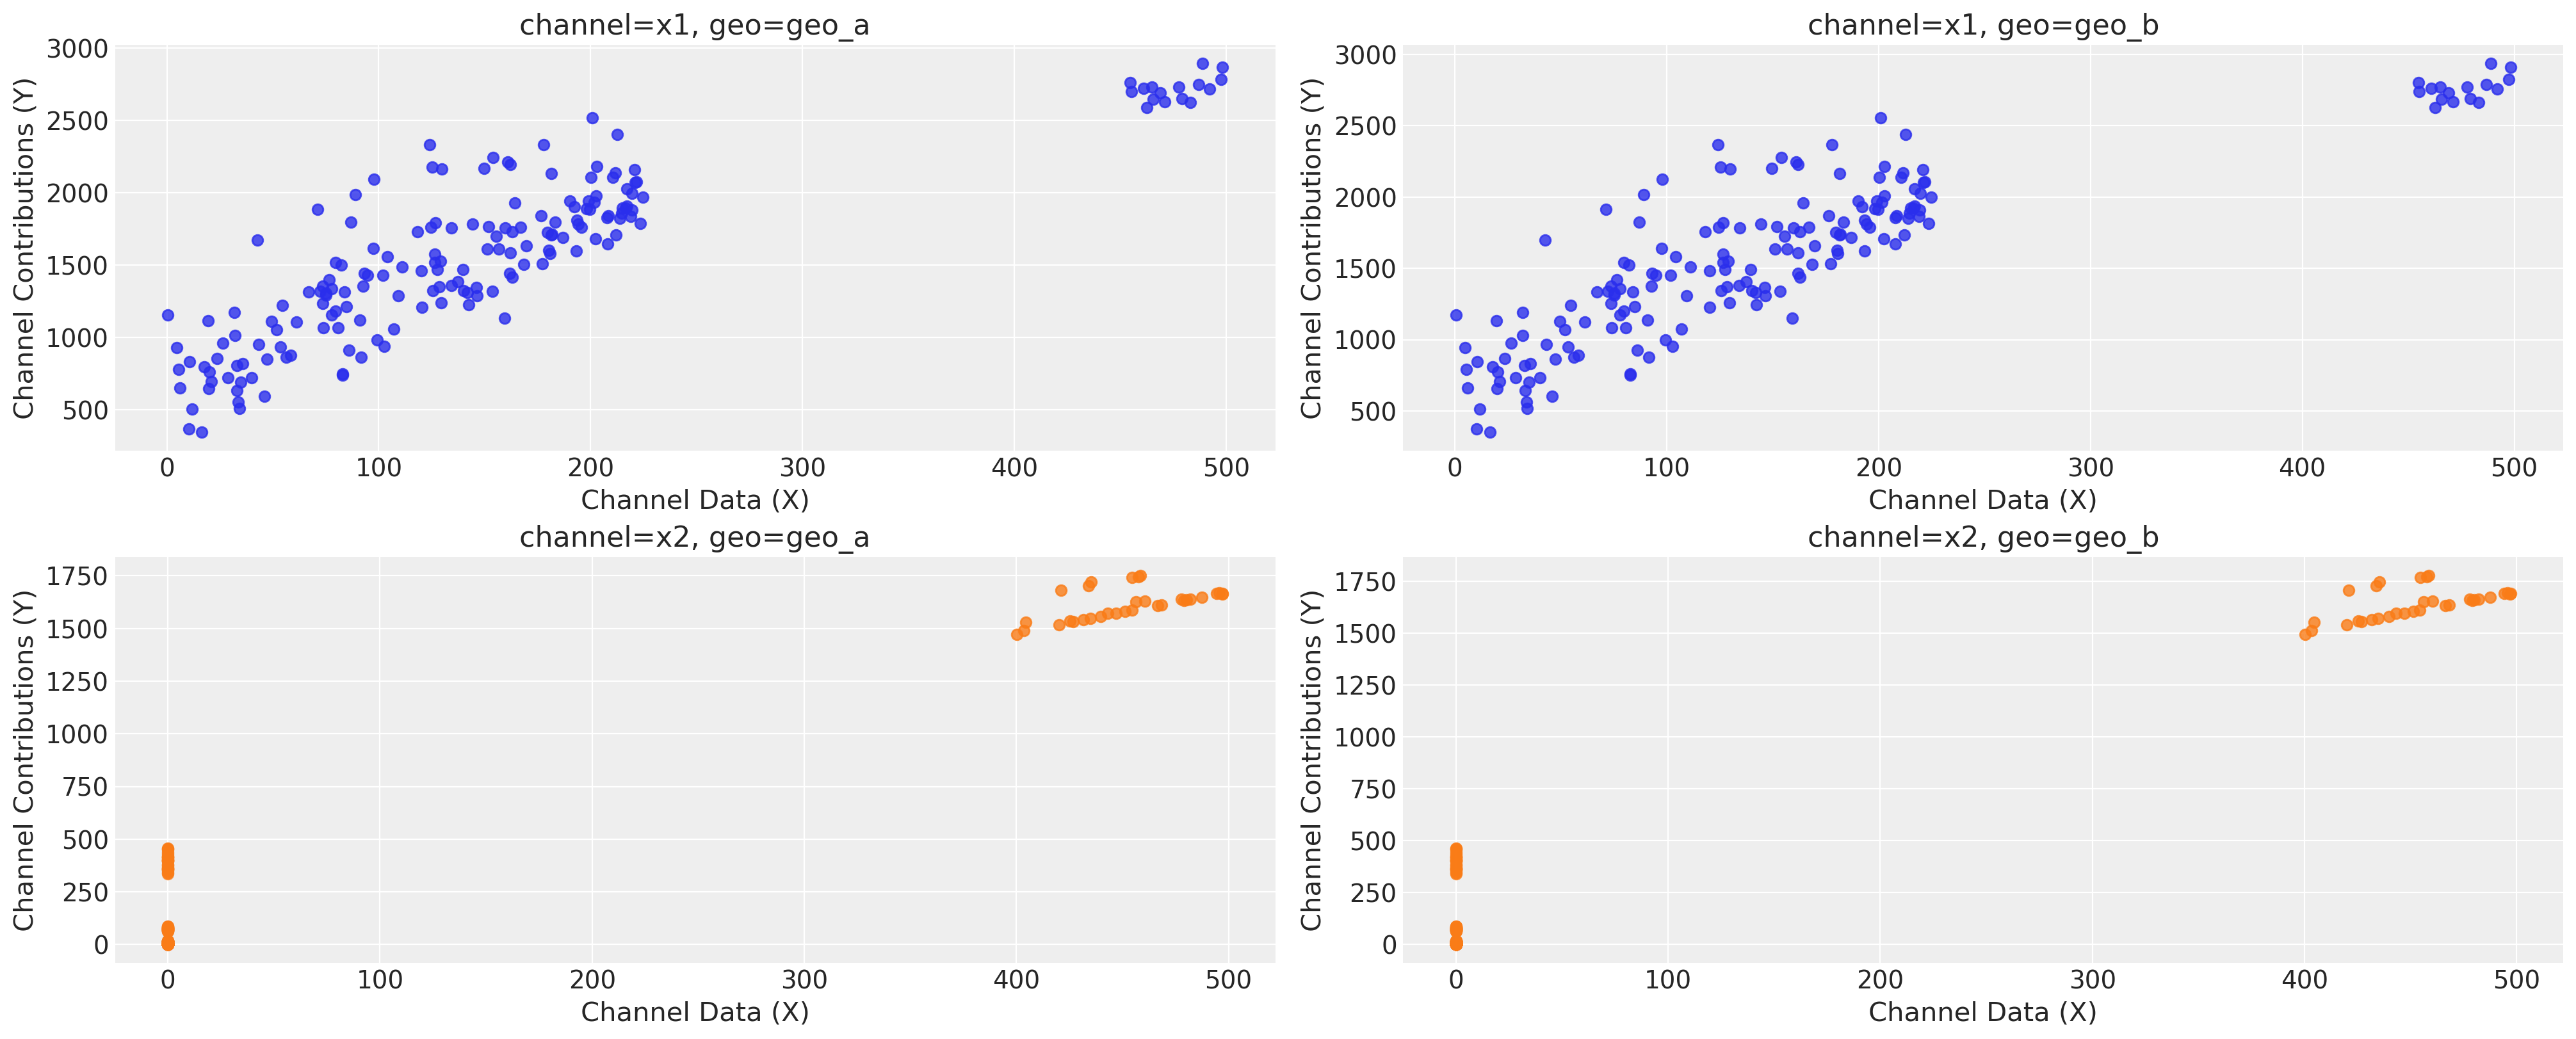

In [7]:
mmm.plot.saturation_scatterplot(original_scale=True);

The observable space only encompasses our data points and does not illustrate what transpires beyond those points. As a result, it is not assured that the maximum contribution point for each channel lies within this observable range.

If we want to visualize certain level of response, we can use `sample_curve` to get an estimate of our response in scaled space given a max value of X in scaled space as well. In the example below, we are using the value `3` which represent 3X the max historical value on each channel. Depending on your scaling method, `max_value` could represent a different thing.


After it, using the function `saturation_curves`, we can predict the shape of the model fitting curve for the amount spent that was not previously observed.

Sampling: []


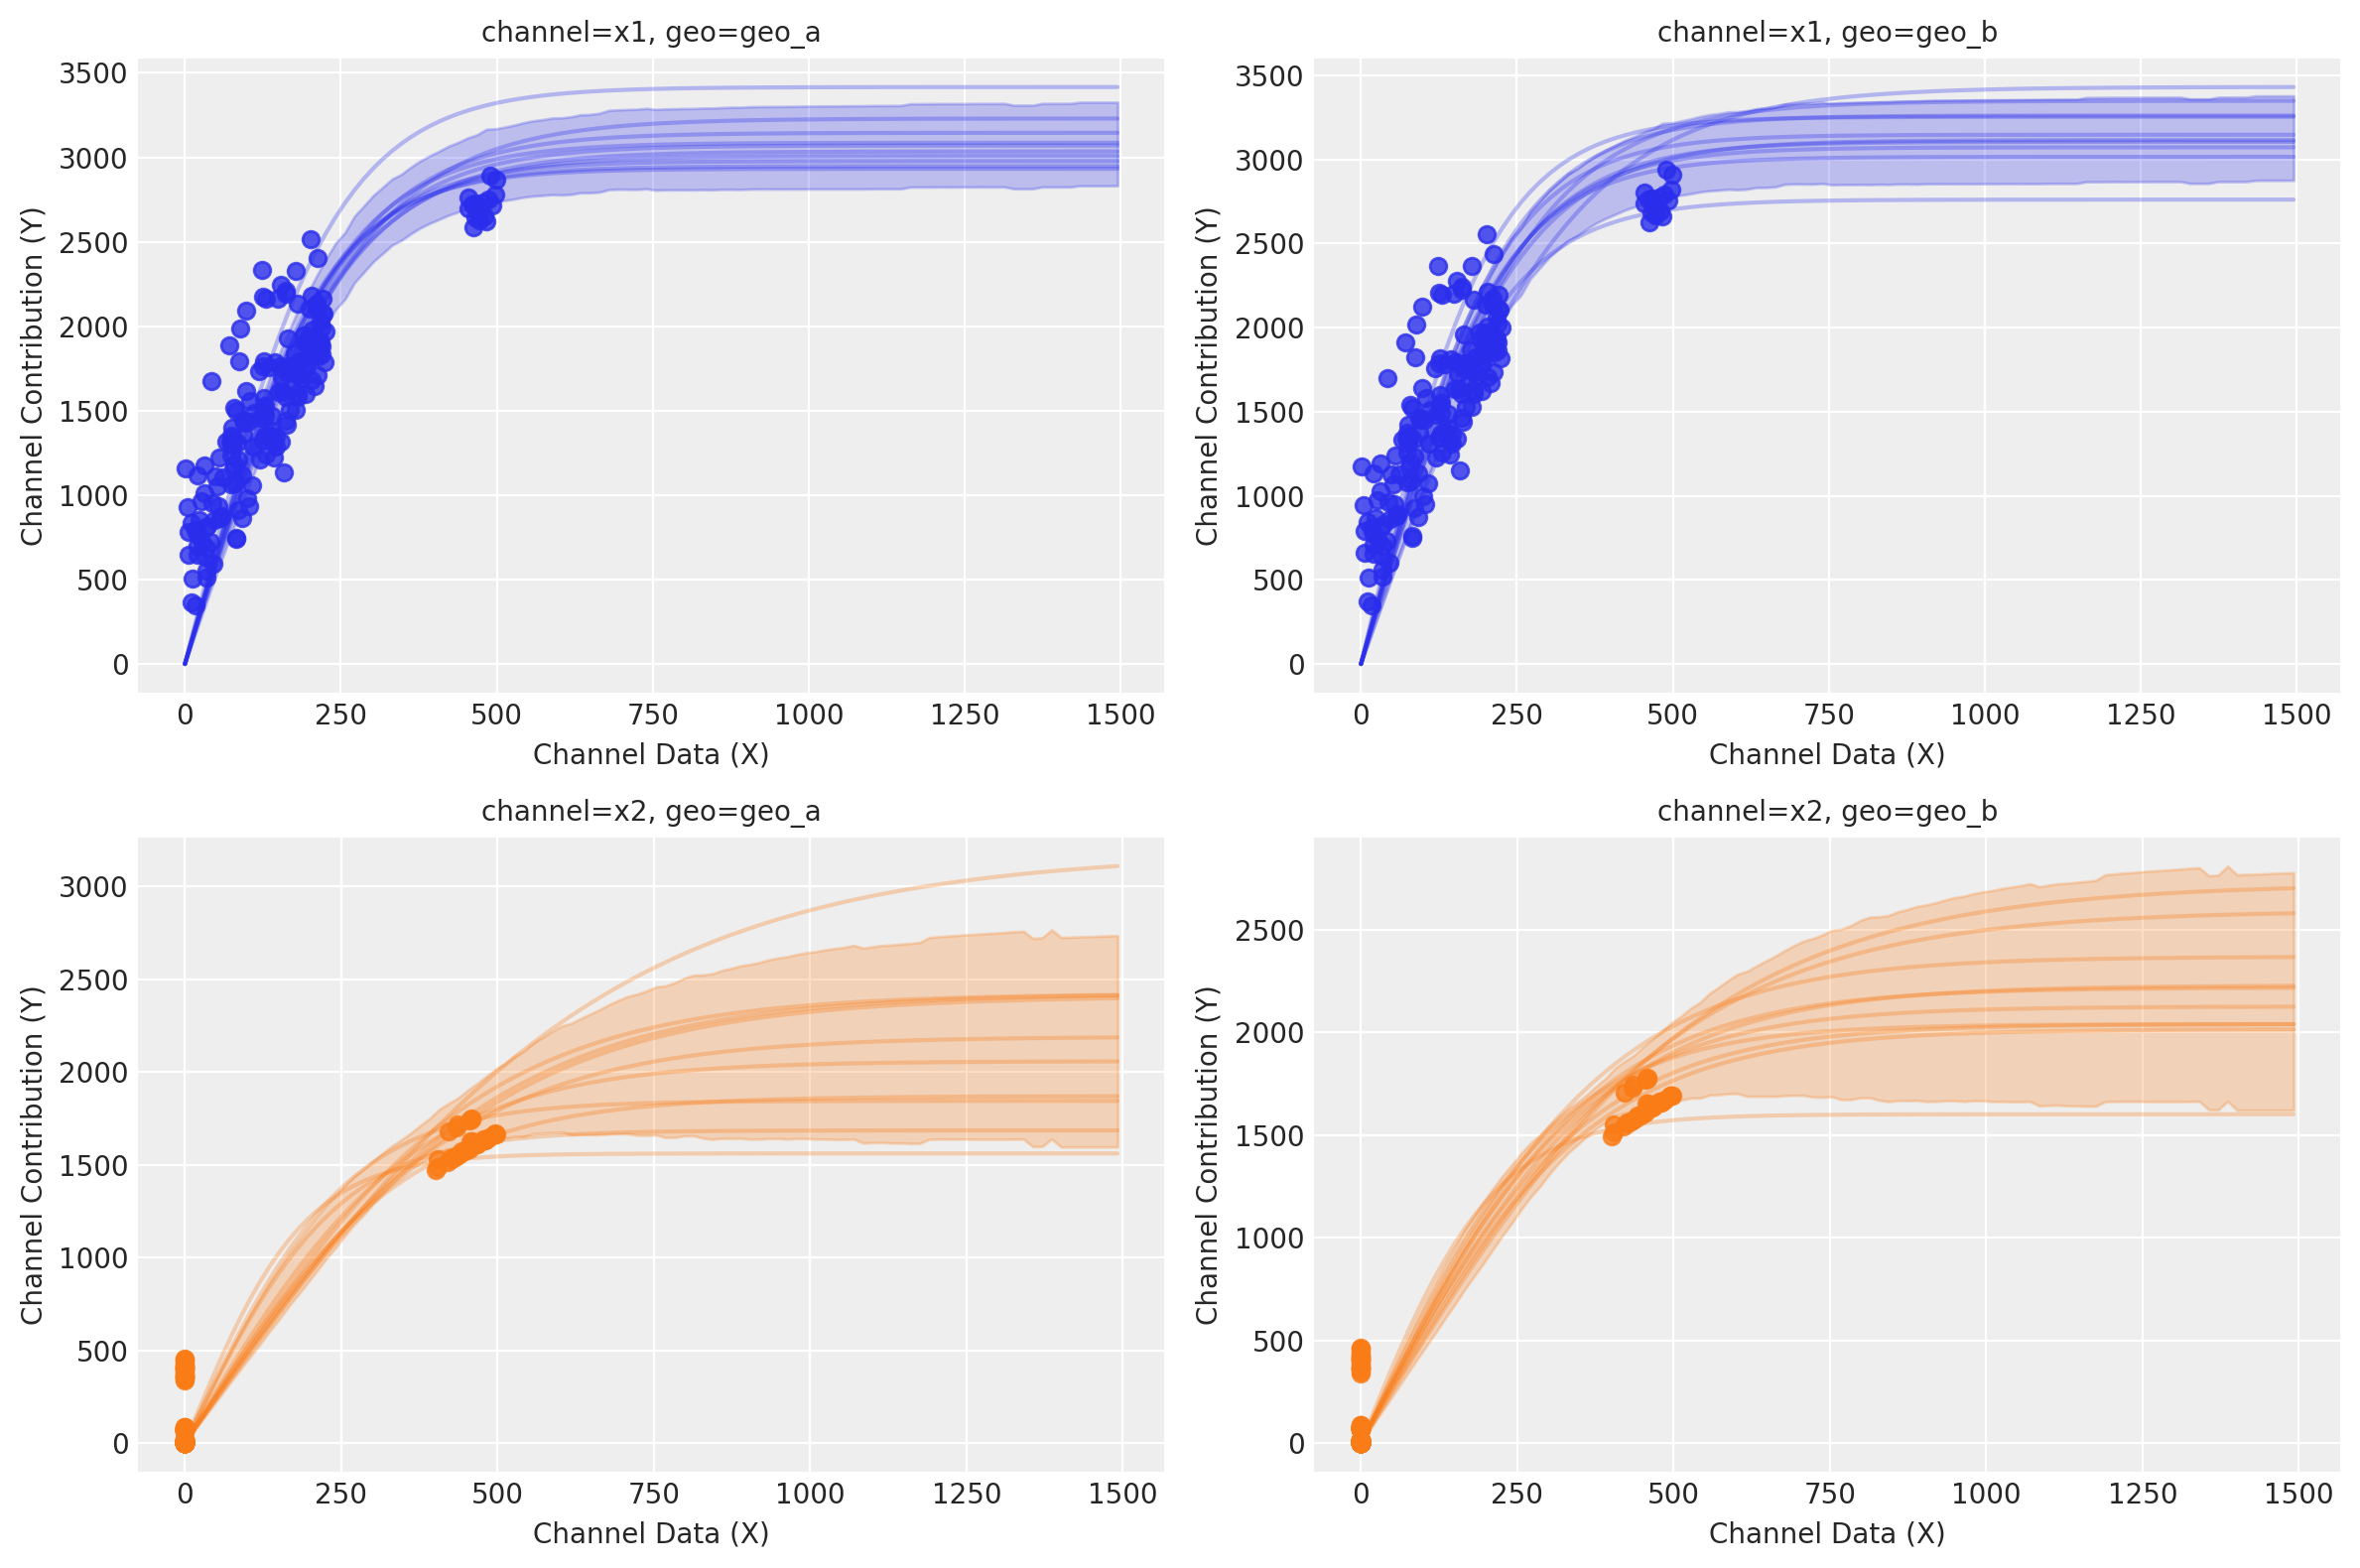

In [8]:
curve = mmm.saturation.sample_curve(
    mmm.idata.posterior[["saturation_beta", "saturation_lam"]], max_value=3
)
fig, axes = mmm.plot.saturation_curves(
    curve,
    original_scale=True,
    n_samples=10,
    hdi_probs=0.85,
    random_seed=rng,
    subplot_kwargs={"figsize": (12, 8), "ncols": 2},
    rc_params={
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "axes.labelsize": 10,
        "axes.titlesize": 10,
    },
)

for ax in axes.ravel():
    ax.title.set_fontsize(10)

if fig._suptitle is not None:
    fig._suptitle.set_fontsize(12)

plt.tight_layout()
plt.show()

The fit of the model comes from the saturation function selected at the time of training. You can verify this by directly accessing the model method and plotting the class name.

In [9]:
print(f"Model was train using the {mmm.saturation.__class__.__name__} function")
print(f"and the {mmm.adstock.__class__.__name__} function")

Model was train using the LogisticSaturation function
and the GeometricAdstock function


Within PyMC-Marketing we have different saturation functions, you can observe all in the [transformer module](https://www.pymc-marketing.io/en/stable/api/generated/pymc_marketing.mmm.transformers.html).

Let's understand a few saturation functions with a few examples!

## Understanding Saturation Functions: Sigmoid and Michaelis-Menten
What do we mean by saturation functions? We assume the effect of spend on sales is not linear and saturates at some point. Two prevalent functions deployed to comprehend and estimate the saturation effects in advertising channels are the sigmoid and the Michaelis-Menten functions.

### Sigmoid Function
The sigmoid function is formulated as:

$$
\beta \cdot \frac{\exp(-\lambda x)}{1 + \exp(-\lambda x)}
$$

Key Elements:
* β (beta): Denotes the Asymptotic Maximum or Ceiling Value. It is the point that the function approaches as the input x becomes immense.
* λ (Lambda): Influences the steepness of the curve. A more substantial value of λ renders the curve steeper, while a lesser value makes it more even-paced.

### Michaelis-Menten Function
The Michaelis-Menten function is formulated as:

$$
\frac{\alpha \times x}{\lambda + x}
$$

Key Elements:
* α (Alpha or Vmax): It represents the maximum contribution (y) a channel can make, also recognized as the plateau point.
* λ (k): Denotes the elbow on the function in x, signifying the moment when the curve adjusts its direction.

## Which Function to Use?
The preference between the sigmoid and Michaelis-Menten functions ought to be steered by the data's goodness of fit. But it really comes down to your assumptions about where the peak might be and the speed at which it saturates the curve.

> **Tip**: When you're choosing a saturation function, it's helpful to consider the data you already have. While saturation functions may have different parameterizations, they all have the same effect. If you already know about any relationship between spending and response, it's a good idea to pick a function with the same parameter values. This will help you understand and analyze its operation and outcomes better, which is essential within the Bayesian framework.

Once these parameters are obtained, you can visualize it using the `arviz.summary` function (each parameter has the prefix `saturation` or `adstock` respectively) and, if desired, you can recreate the curves for each channel independently based on them. More crucially, these parameter values are indispensable when using the `budget_allocator` function, which leverages this information to optimize your marketing budget across distinct channels. This section is fundamental to budget optimization.

In [10]:
az.summary(
    data=mmm.fit_result,
    var_names=[
        "saturation_beta",
        "saturation_lam",
        "adstock_alpha",
    ],
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
saturation_beta[x1]  0.371  0.021   0.332    0.410      0.000    0.000   
saturation_beta[x2]  0.273  0.062   0.190    0.390      0.001    0.002   
saturation_lam[x1]   4.013  0.419   3.166    4.757      0.008    0.008   
saturation_lam[x2]   2.728  0.983   1.187    4.665      0.021    0.022   
adstock_alpha[x1]    0.395  0.033   0.335    0.458      0.001    0.000   
adstock_alpha[x2]    0.183  0.041   0.105    0.257      0.001    0.001   

                     ess_bulk  ess_tail  r_hat  
saturation_beta[x1]    2785.0    2715.0    1.0  
saturation_beta[x2]    2107.0    2185.0    1.0  
saturation_lam[x1]     2692.0    2344.0    1.0  
saturation_lam[x2]     2156.0    1996.0    1.0  
adstock_alpha[x1]      3571.0    3268.0    1.0  
adstock_alpha[x2]      2940.0    2526.0    1.0

## Example Use-Cases
The `optimize_budget` function within PyMC-Marketing boasts a myriad of applications that can solve various business predicaments. Here, we present five critical use cases that exemplify its utility in real-world marketing scenarios.

### What are we optimizing?
Before jumping into the examples, we need to understand the basis of our optimizer.

We aim to optimize the allocation of budgets across multiple channels to maximize the overall contribution to key performance indicators (KPIs), such as sales or conversions. Each channel has its own forward pass function, which can internal consider a sigmoid or michaelis-menten curve, representing the relationship between the amount spent and the resultant performance.

These curves vary in characteristics: some channels saturate quickly, meaning that additional spending yields diminishing returns, while others may offer more linear growth in contribution with increased spending.

To solve this optimization problem, we employ the Sequential Least Squares Quadratic Programming ([SLSQP](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html#optimize-minimize-slsqp)) algorithm, a gradient-based optimization technique. SLSQP is well-suited for this application as it allows for the imposition of both equality and inequality constraints, ensuring that the budget allocation adheres to business rules or limitations.

The algorithm works by iteratively approximating the objective function and constraints using quadratic functions and solving the resulting sub-problems to find a local minimum. This enables us to effectively navigate the multidimensional space of budget allocations to find the most efficient distribution of resources.

The optimizer aims to maximize the total contribution from all channels while adhering to the following constraints:

1. Budget Limitations: The total spending across all channels should not exceed the overall marketing budget.
2. Channel-specific Constraints: Some channels may have minimum or maximum spending limits.

By leveraging the SLSQP algorithm, we can optimize the multi-channel budget allocation in a rigorous, mathematically sound manner, ensuring that we get the highest possible return on investment.

### Maximizing Contribution
Assume you're managing the marketing for a retail company with a substantial budget to allocate for advertising across multiple channels. Given that, you're contemplating ways to optimize the forthcoming quarter's outlay to maximize the overall contribution.

You might have considered scattering your money in the same way than you did historically without an MMM model - let's repeat the know formula. However, you wish to explore better alternatives now that you possess an MMM model. Given that you lack prior knowledge, you impose the same restrictions on both channels. They must each expend a minimum of 500 euros and no more than 2,000 euros, equating to your total budget.

In [11]:
from pymc_marketing.mmm.budget_optimizer import optimizer_xarray_builder

time_unit_budget = 4_000  # Budget per time unit
campaign_period = 12  # Number of time units
print(
    f"Total budget for the {campaign_period} Weeks: {time_unit_budget * campaign_period:,}"
)
# Define your channels
channels = ["x1", "x2"]
geos = ["geo_a", "geo_b"]
# The initial split per channel
budget_per_channel = time_unit_budget / (len(channels) * len(geos))
# Initial budget per channel.
initial_budget = optimizer_xarray_builder(
    np.array(
        [
            [budget_per_channel * 0.5, budget_per_channel * 1.5],
            [budget_per_channel * 0.6, budget_per_channel * 1.4],
        ]
    ),
    channel=channels,
    geo=geos,
)  # Using this function we can create the initial allocation strategy for each channel and geo

print("-" * 50)
print("Budget per channel per geo:")
for geo in geos:
    for channel in channels:
        print(
            f"  {geo} - {channel}: {initial_budget.sel(geo=geo, channel=channel).item():.2f}"
        )

# bounds for each channel
min_budget, max_budget = 500, 2_000
budget_bounds = optimizer_xarray_builder(
    np.array(
        [
            [[min_budget, max_budget], [min_budget, max_budget]],
            [[min_budget, max_budget], [min_budget, max_budget]],
        ]
    ),
    channel=channels,
    geo=geos,
    bound=["lower", "upper"],
)  # Using this function we can create a budget bounds for each channel and geo as well

Total budget for the 12 Weeks: 48,000
--------------------------------------------------
Budget per channel per geo:
  geo_a - x1: 500.00
  geo_a - x2: 600.00
  geo_b - x1: 1500.00
  geo_b - x2: 1400.00


Our current model was trained with weekly data, meaning each period (time unit) represents a week. If we plan to create a budget allocation for a specific quarter, we need to add 12 weeks to our initial date. By doing so, we can initialize our class that wraps our **MMM**.

In [12]:
# Get the maximum date and add one day to it
max_date = mmm.idata.posterior.coords["date"].max().item()
start_date = (
    pd.Timestamp(max_date) + pd.Timedelta(weeks=1)
).strftime(  # mmm.adstock.l_max+2
    "%Y-%m-%d"
)

end_date = (pd.Timestamp(start_date) + pd.Timedelta(weeks=campaign_period)).strftime(
    "%Y-%m-%d"
)

print(f"Start date: {start_date}, End date: {end_date}")

Start date: 2021-09-06, End date: 2021-11-29


In [13]:
optimizable_model = MultiDimensionalBudgetOptimizerWrapper(
    model=mmm, start_date=start_date, end_date=end_date
)

Before we proceed to evaluate the effectiveness of our optimization, we can estimate the response by following our initial plan, which involves distributing our budget based on historical spending patterns.

In [14]:
sample_response_give_initial_budget = optimizable_model.sample_response_distribution(
    allocation_strategy=initial_budget,  # Here we add the initial budget allocation strategy
    include_carryover=True,
    include_last_observations=False,
)

Sampling: [y]


The response will be expose as a data array with different variables, such as:
- y (Target variables)
- allocation (The allocation strategy shared)
- channel variables (Every channel column with the corresponding units used to get the prediction).
- Total Media Channel Contribution in Original Scale (The posterior distribution of the sum of media channel by date)

In [15]:
sample_response_give_initial_budget

<xarray.Dataset> Size: 4MB
Dimensions:                                  (date: 21, geo: 2, sample: 4000,
                                              channel: 2)
Coordinates:
  * date                                     (date) datetime64[ns] 168B 2021-...
  * geo                                      (geo) <U5 40B 'geo_a' 'geo_b'
  * channel                                  (channel) <U2 16B 'x1' 'x2'
  * sample                                   (sample) object 32kB MultiIndex
  * chain                                    (sample) int64 32kB 0 0 0 ... 3 3 3
  * draw                                     (sample) int64 32kB 0 1 ... 998 999
Data variables:
    y                                        (date, geo, sample) float64 1MB ...
    channel_contribution                     (date, geo, channel, sample) float64 3MB ...
    total_media_contribution_original_scale  (sample) float64 32kB 1.319e+05 ...
    allocation                               (channel, geo) float64 32B 500.0...
    x1                                       (date, geo) float64 336B 500.3 ....
    x2                                       (date, geo) float64 336B 599.0 ....
Attributes:
    created_at:                 2025-07-24T23:11:24.278283+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.25.1

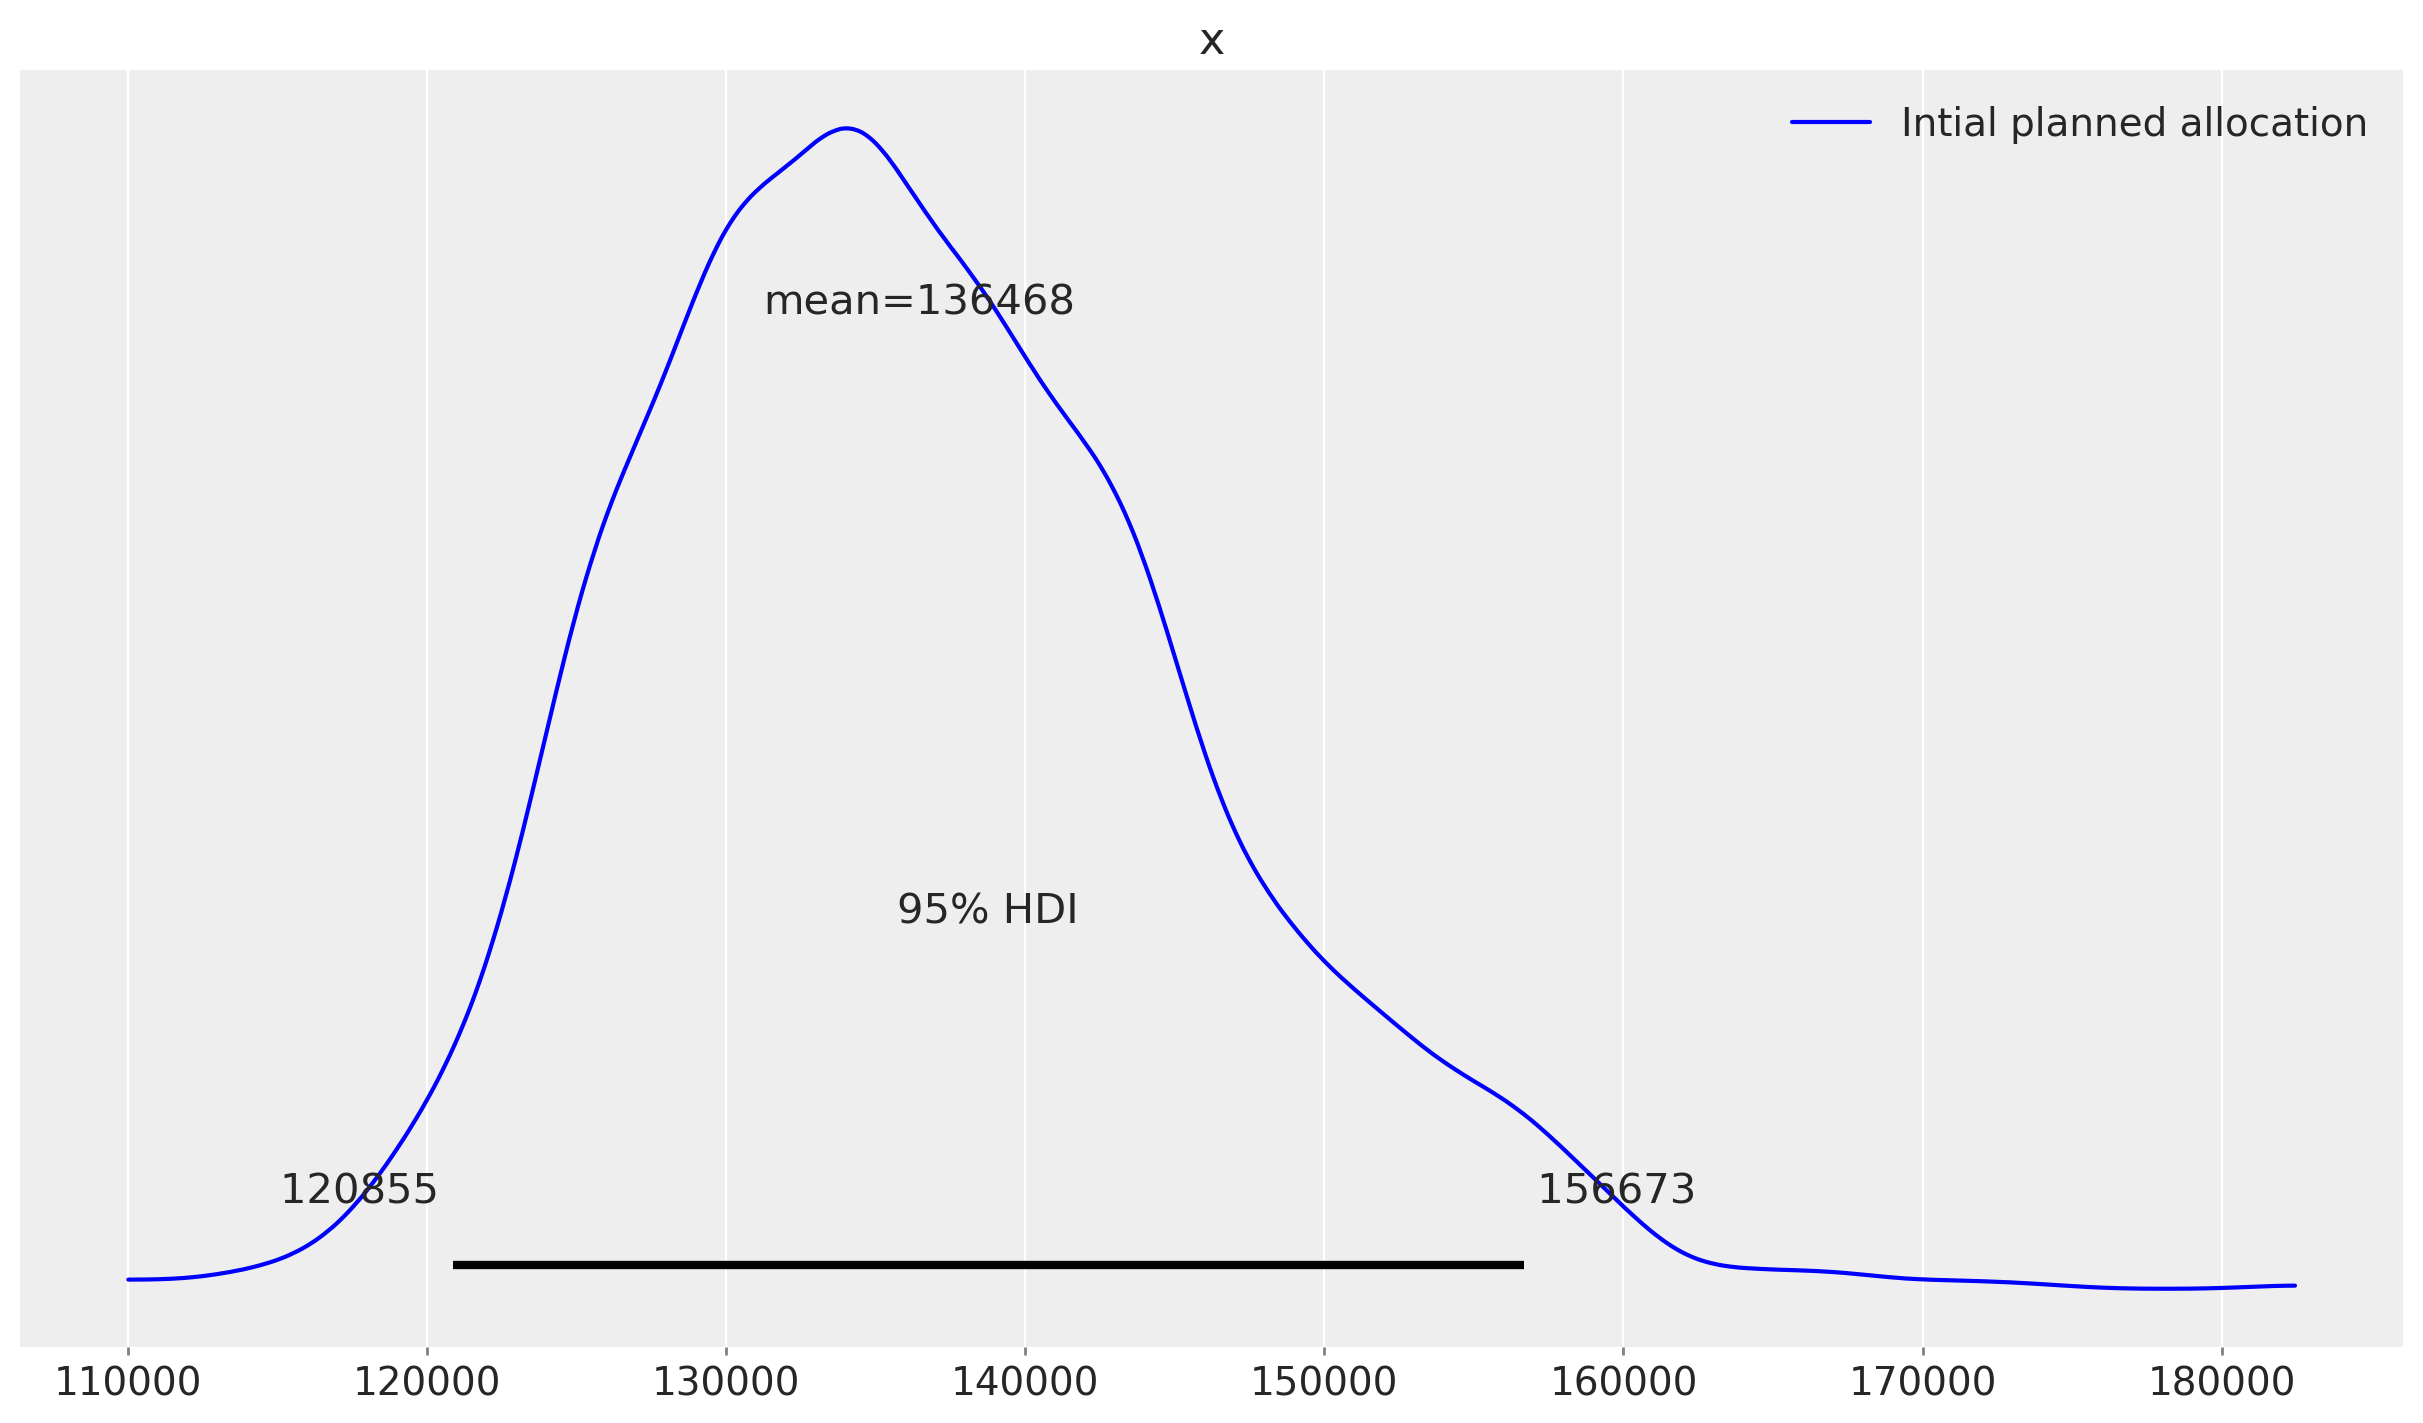

In [16]:
fig, ax = plt.subplots()
az.plot_posterior(
    sample_response_give_initial_budget.total_media_contribution_original_scale.values.flatten(),
    hdi_prob=0.95,
    color="blue",
    label="Intial planned allocation",
    ax=ax,
);

Great, we can see that our initial estimation it's giving us around 141,500 new units (sales in this case) given marketing. But given the same budget, could we do better?

In [17]:
allocation_xarray, res_scipy = optimizable_model.optimize_budget(
    budget=time_unit_budget,  # Total budget to allocate here is spend in Millions
    budget_bounds=budget_bounds,  # Budget bounds for each channel
)

sample_response_given_allocation = optimizable_model.sample_response_distribution(
    allocation_strategy=allocation_xarray,
    include_carryover=True,
    include_last_observations=False,
)

Sampling: [y]


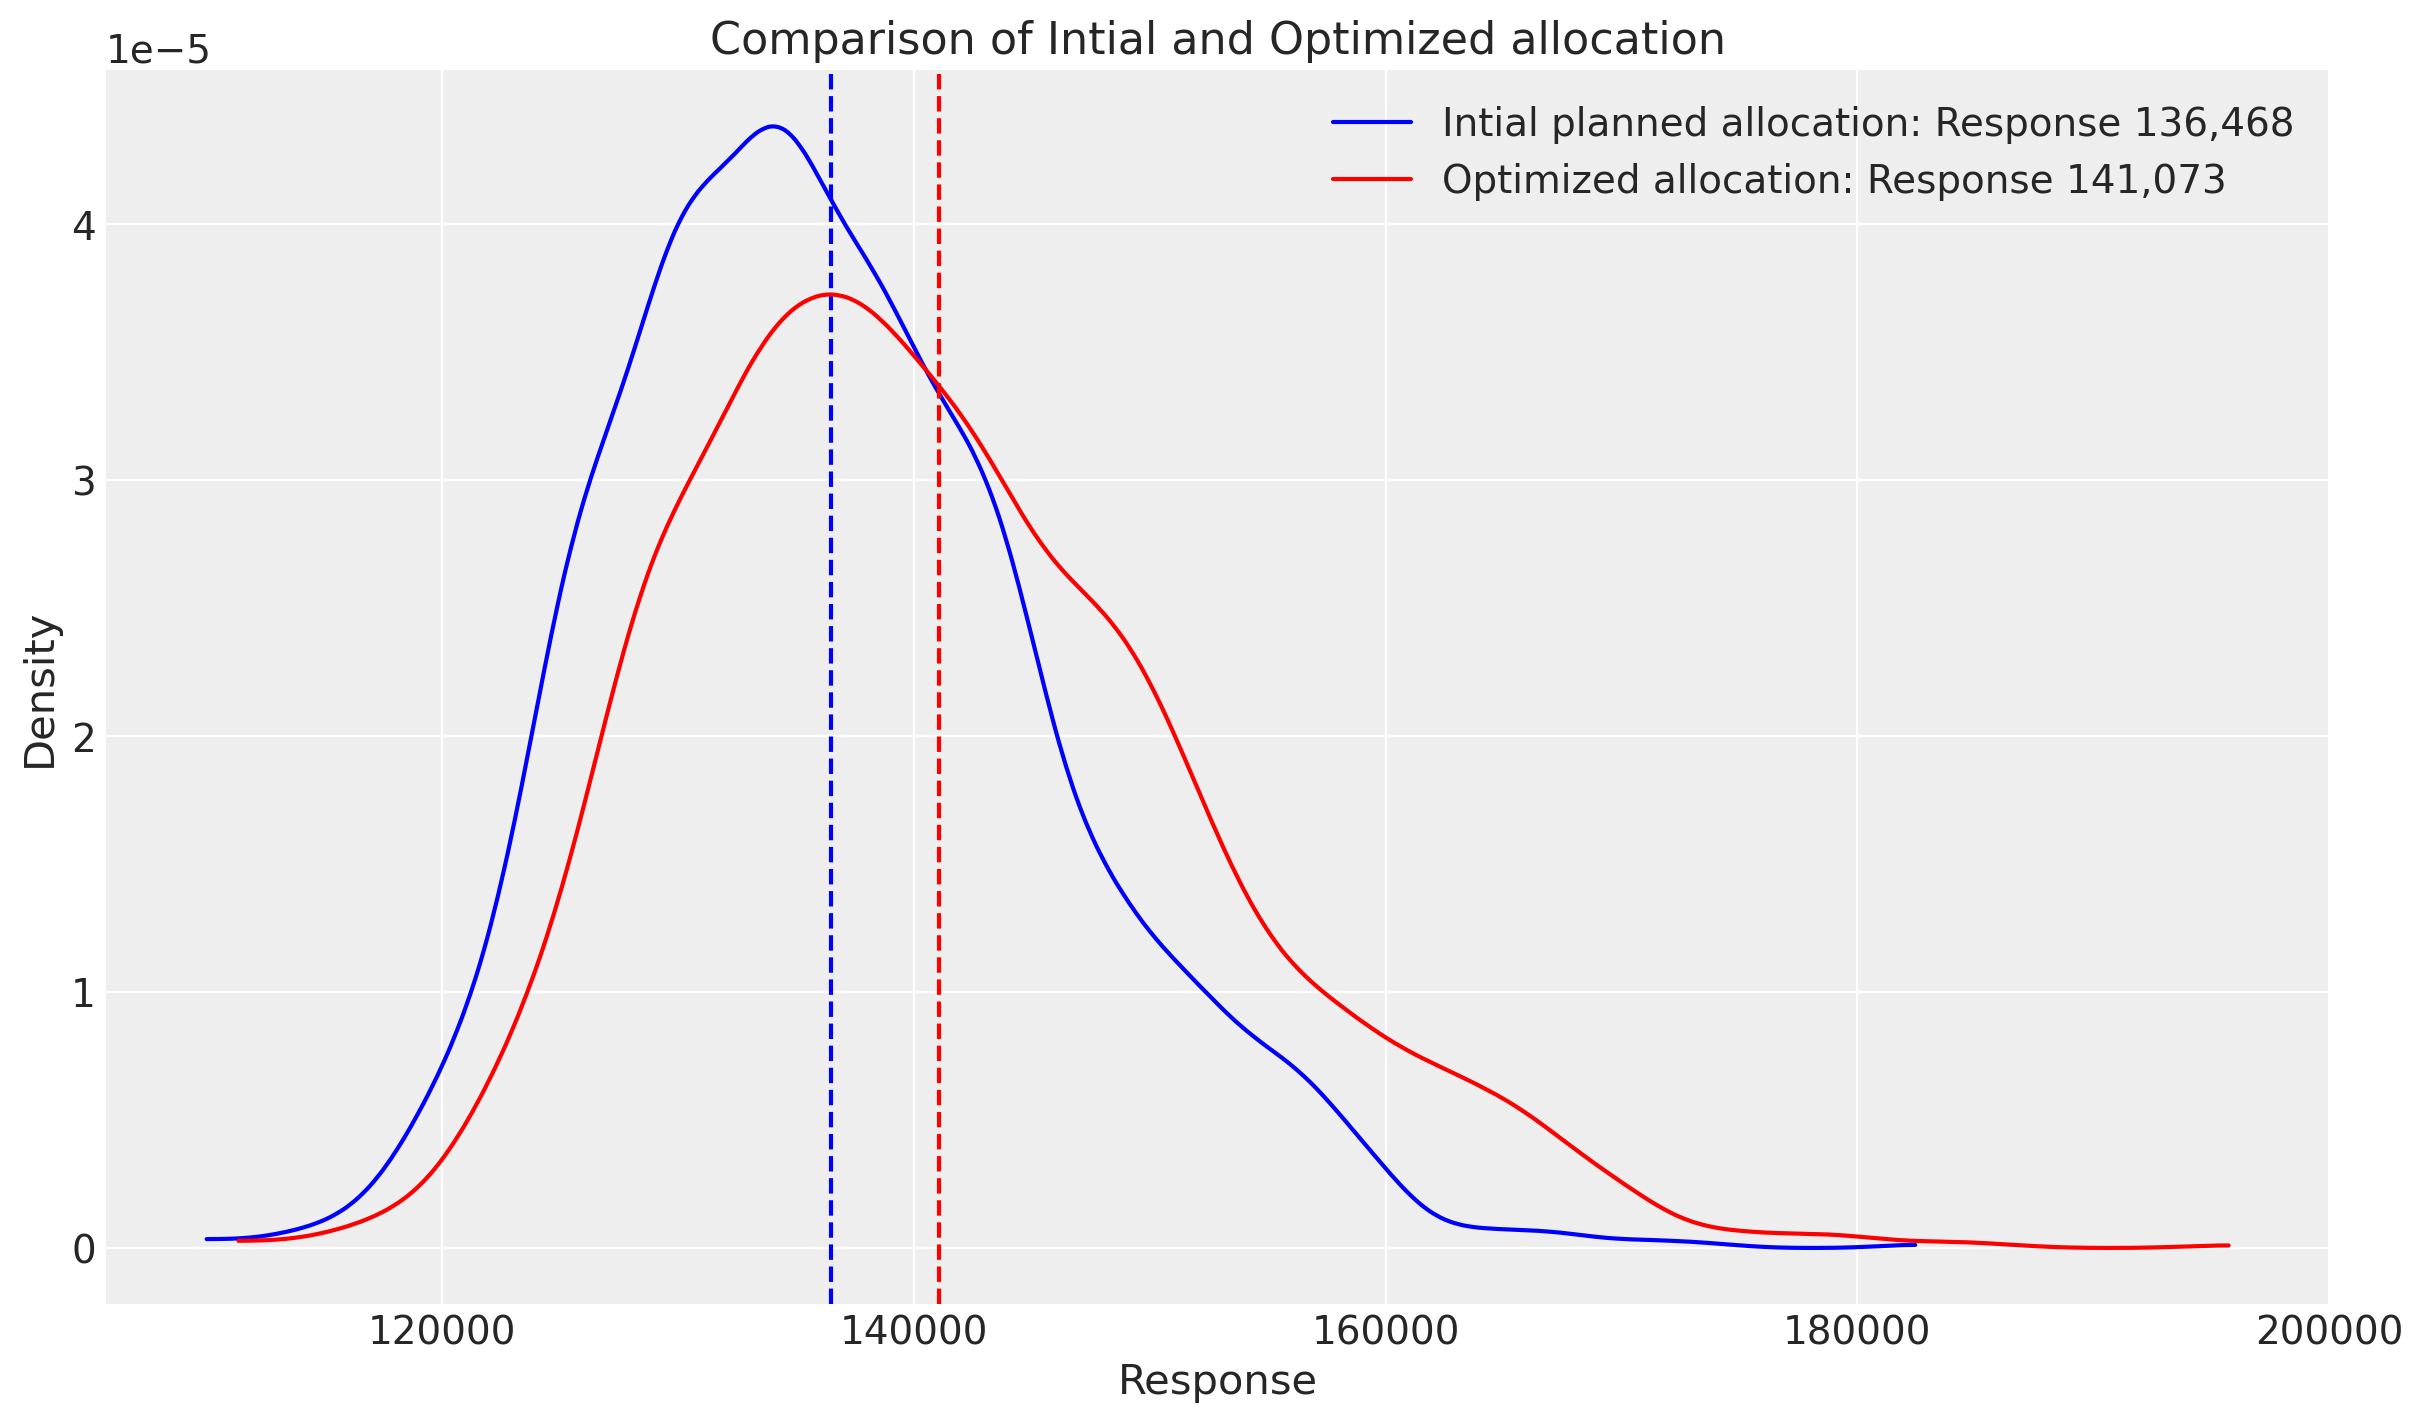

In [18]:
fig, ax = plt.subplots()

# Initial planned allocation
initial_data = sample_response_give_initial_budget.total_media_contribution_original_scale.values.flatten()
initial_mean = initial_data.mean()
az.plot_dist(
    initial_data,
    # hdi_prob=0.75,
    color="blue",
    label=f"Intial planned allocation: Response {initial_mean:,.0f}",
    ax=ax,
    # kind="hist",
)
ax.axvline(initial_mean, color="blue", linestyle="--")

# Optimized allocation
optimized_data = sample_response_given_allocation.total_media_contribution_original_scale.values.flatten()
optimized_mean = optimized_data.mean()
az.plot_dist(
    optimized_data,
    # hdi_prob=0.75,
    color="red",
    label=f"Optimized allocation: Response {optimized_mean:,.0f}",
    ax=ax,
    # kind="hist",
)
ax.axvline(optimized_mean, color="red", linestyle="--")

ax.set_title("Comparison of Intial and Optimized allocation")
ax.set_xlabel("Response")
ax.set_ylabel("Density")
ax.legend()

plt.show()

Great, we can see that given the allocation the optimizer maximize the total response from both channel, and give us back 4_000 extra units, given the same spend. We can visualize the mean response per channel, given the spend using the function `plot.budget_allocation`

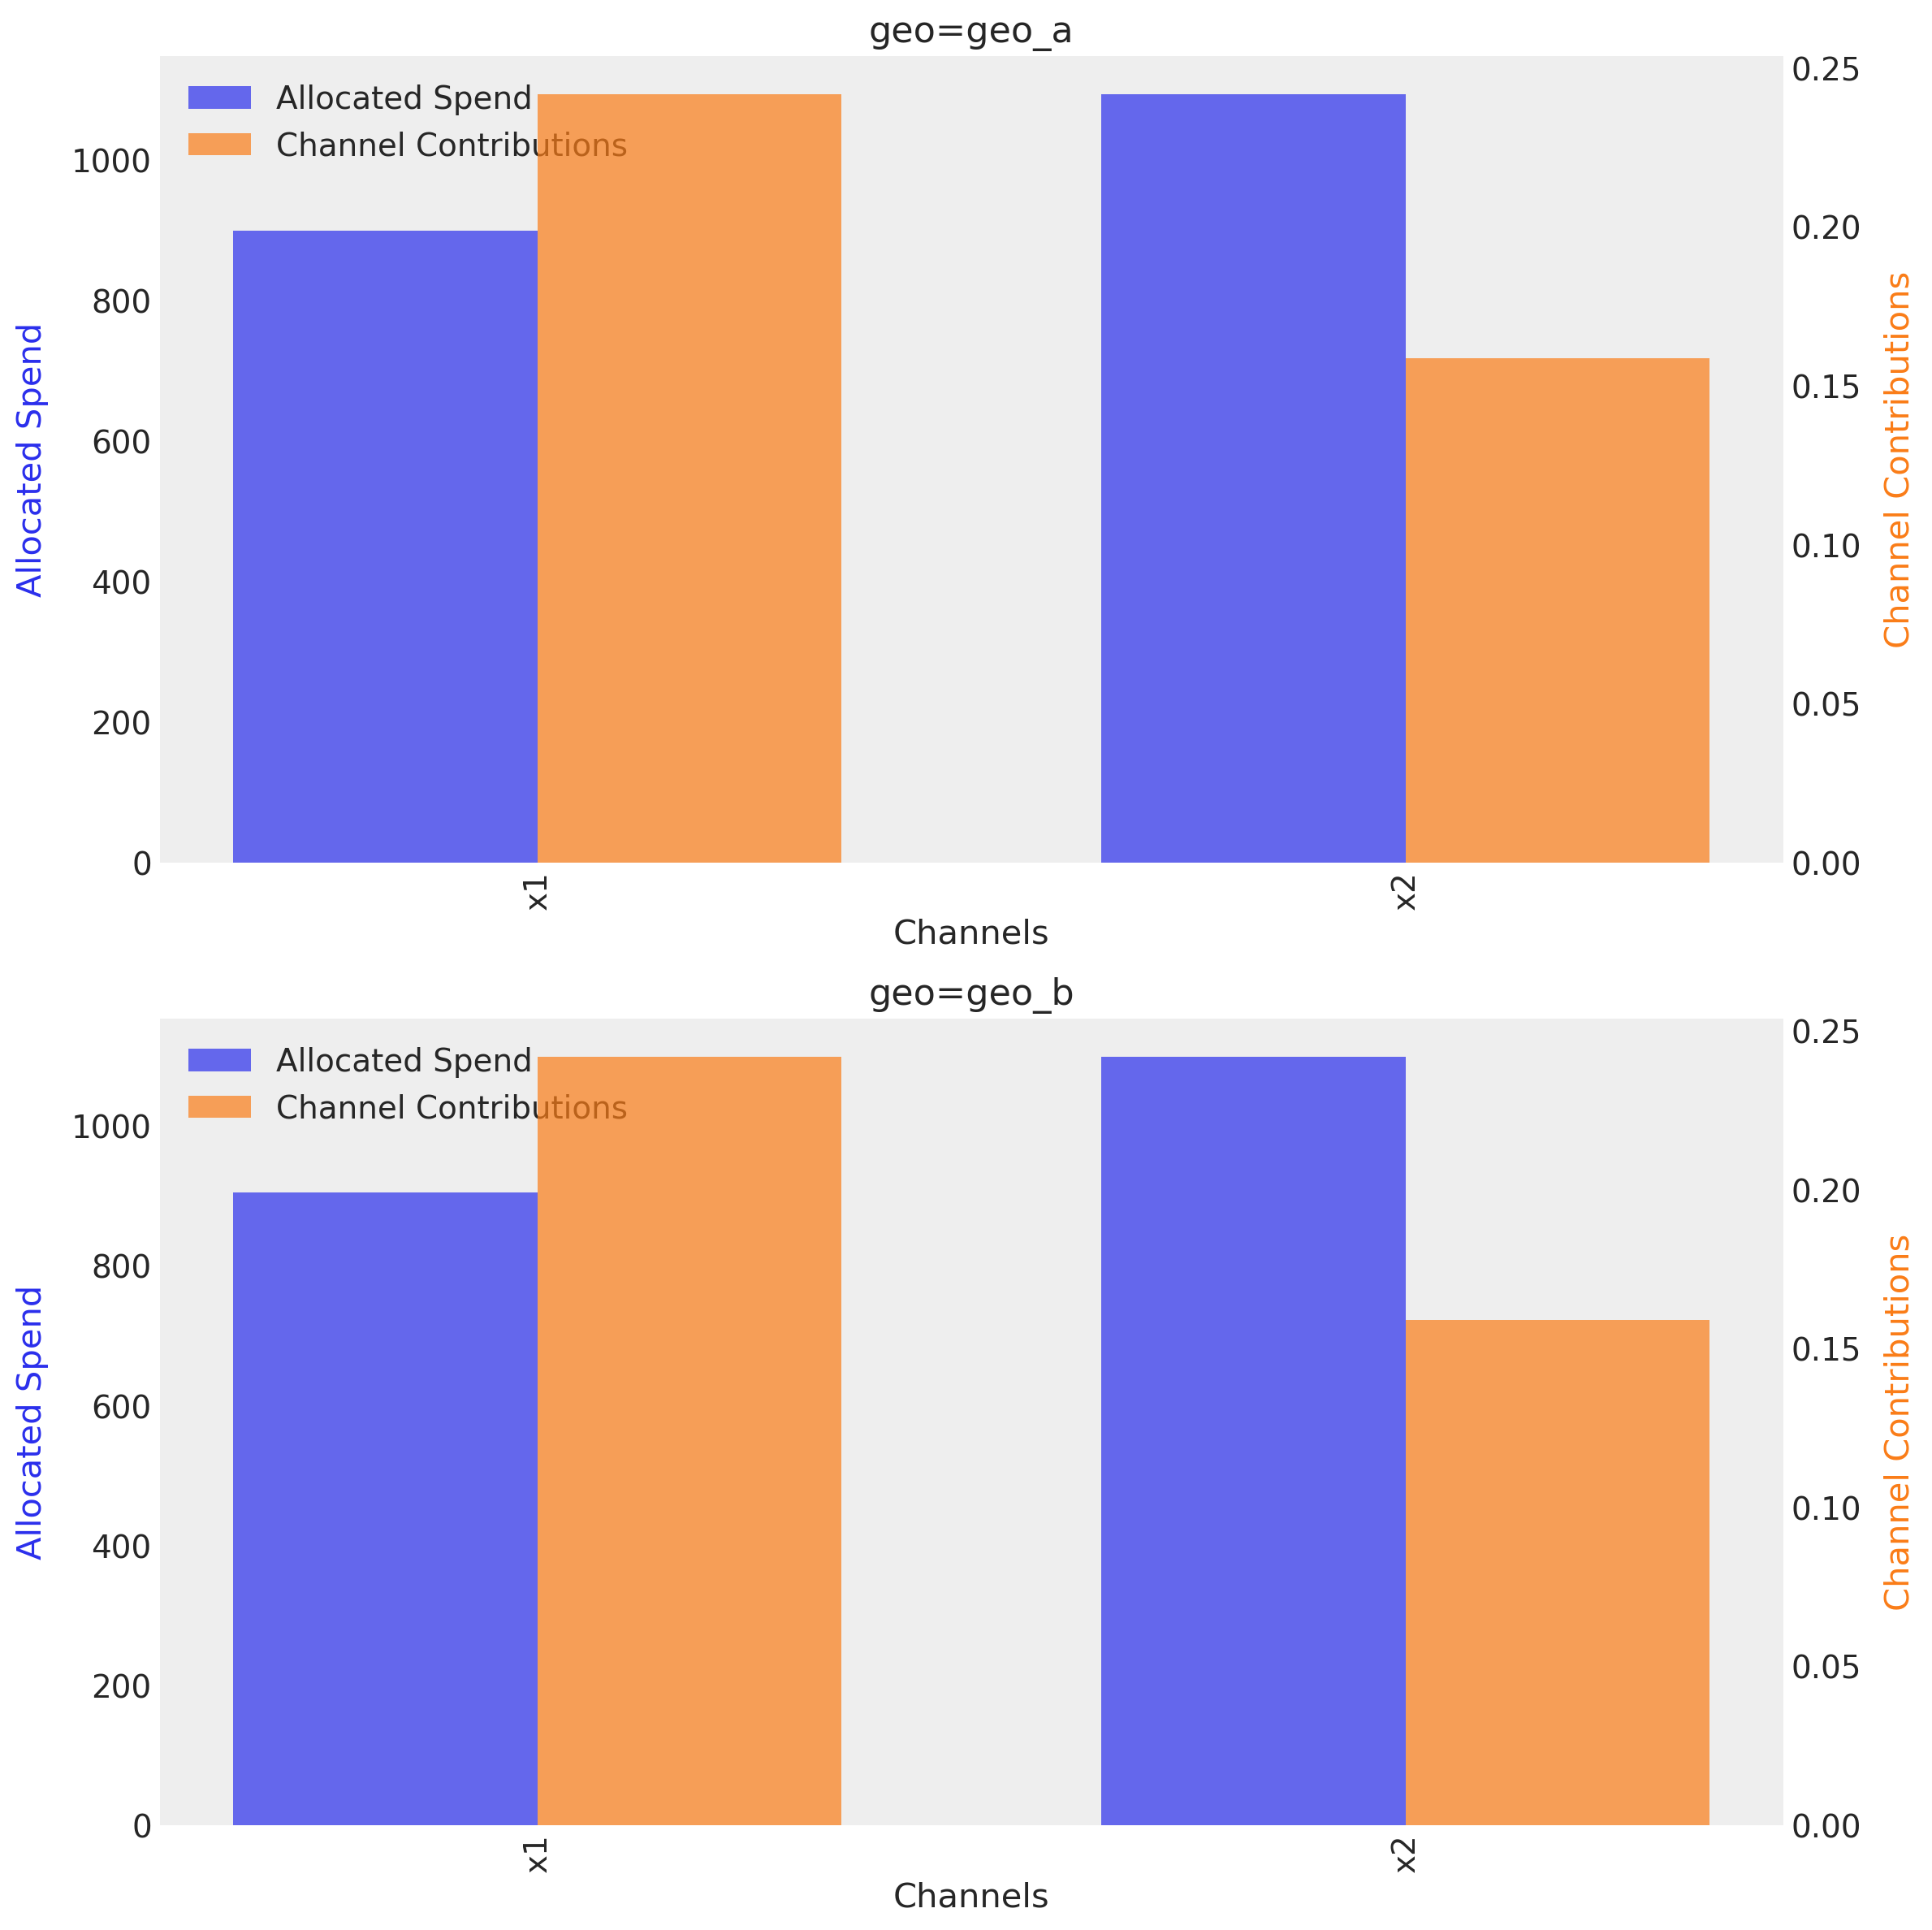

In [19]:
optimizable_model.plot.budget_allocation(
    samples=sample_response_given_allocation,
);

We could visualize the response over time if we want.

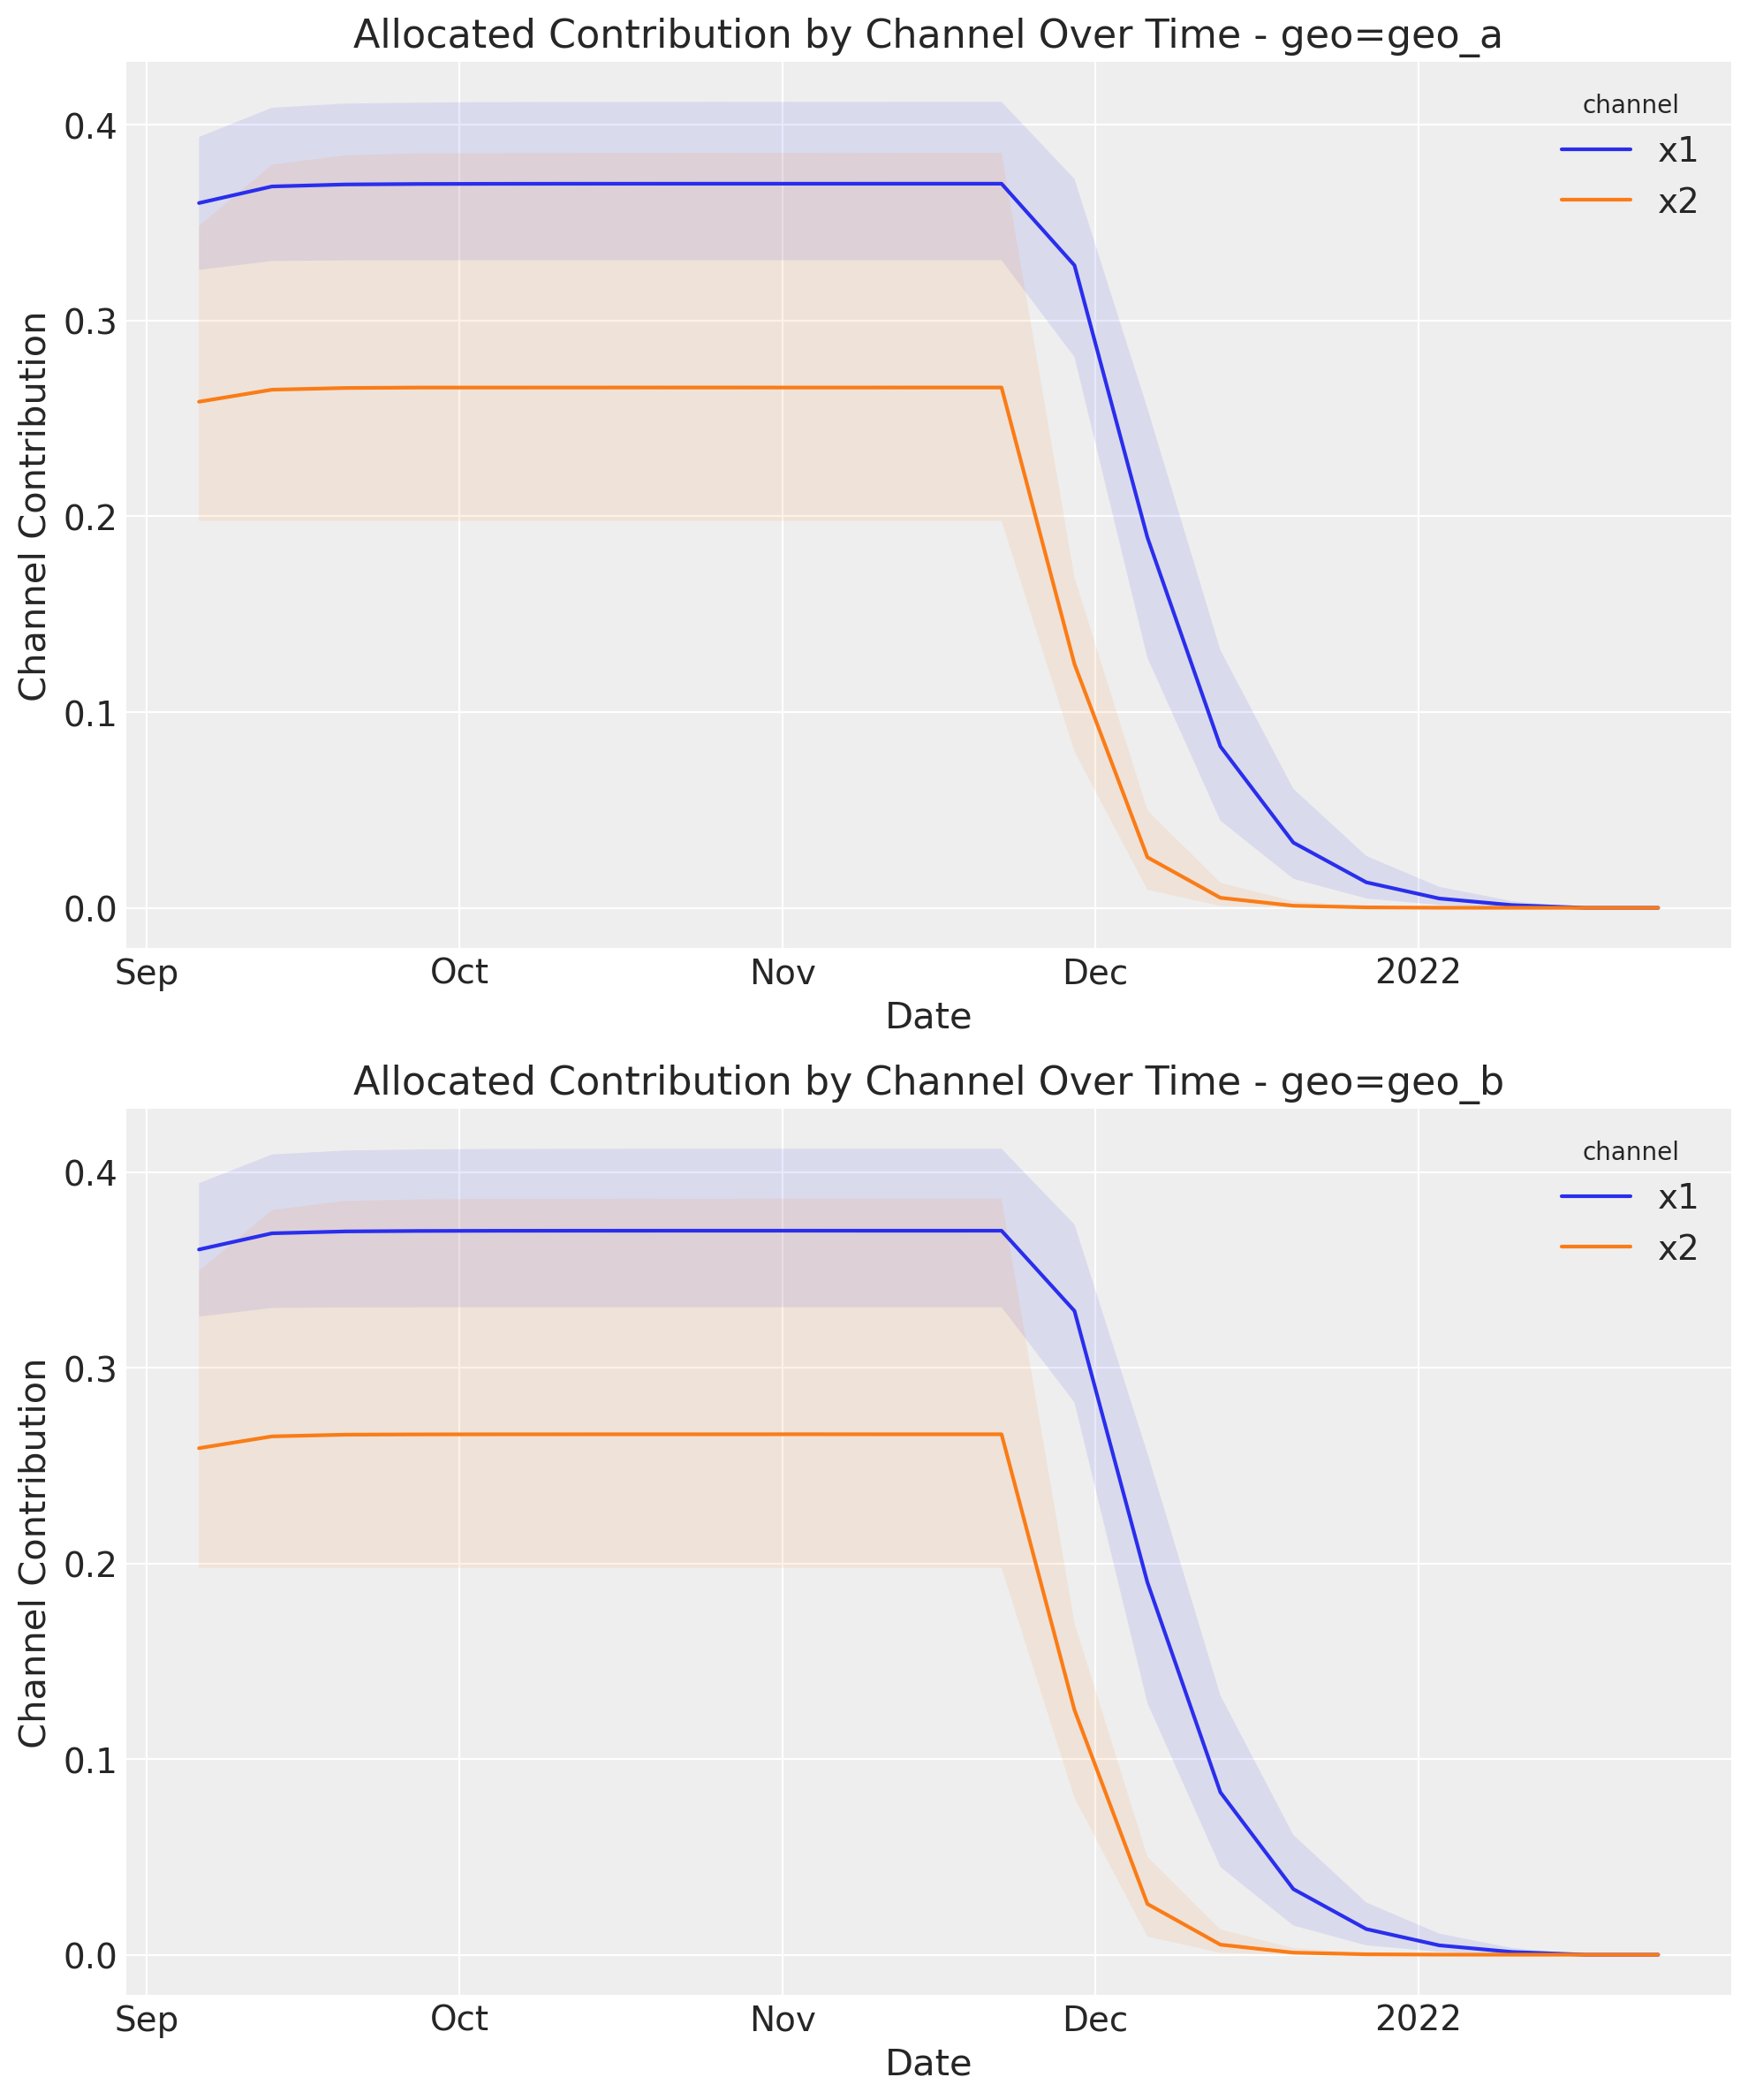

In [20]:
optimizable_model.plot.allocated_contribution_by_channel_over_time(
    samples=sample_response_given_allocation,
);

As you probably, observe the response it's quite flat and saturated. As shown before in the joint distribution of the sum of effects, the mean only increase because the uncertanty was bigger, but majority of the density it's not to far from the biggest density in the initial allocation.

Why this happens? let's take a look to the response curves!

Sampling: []


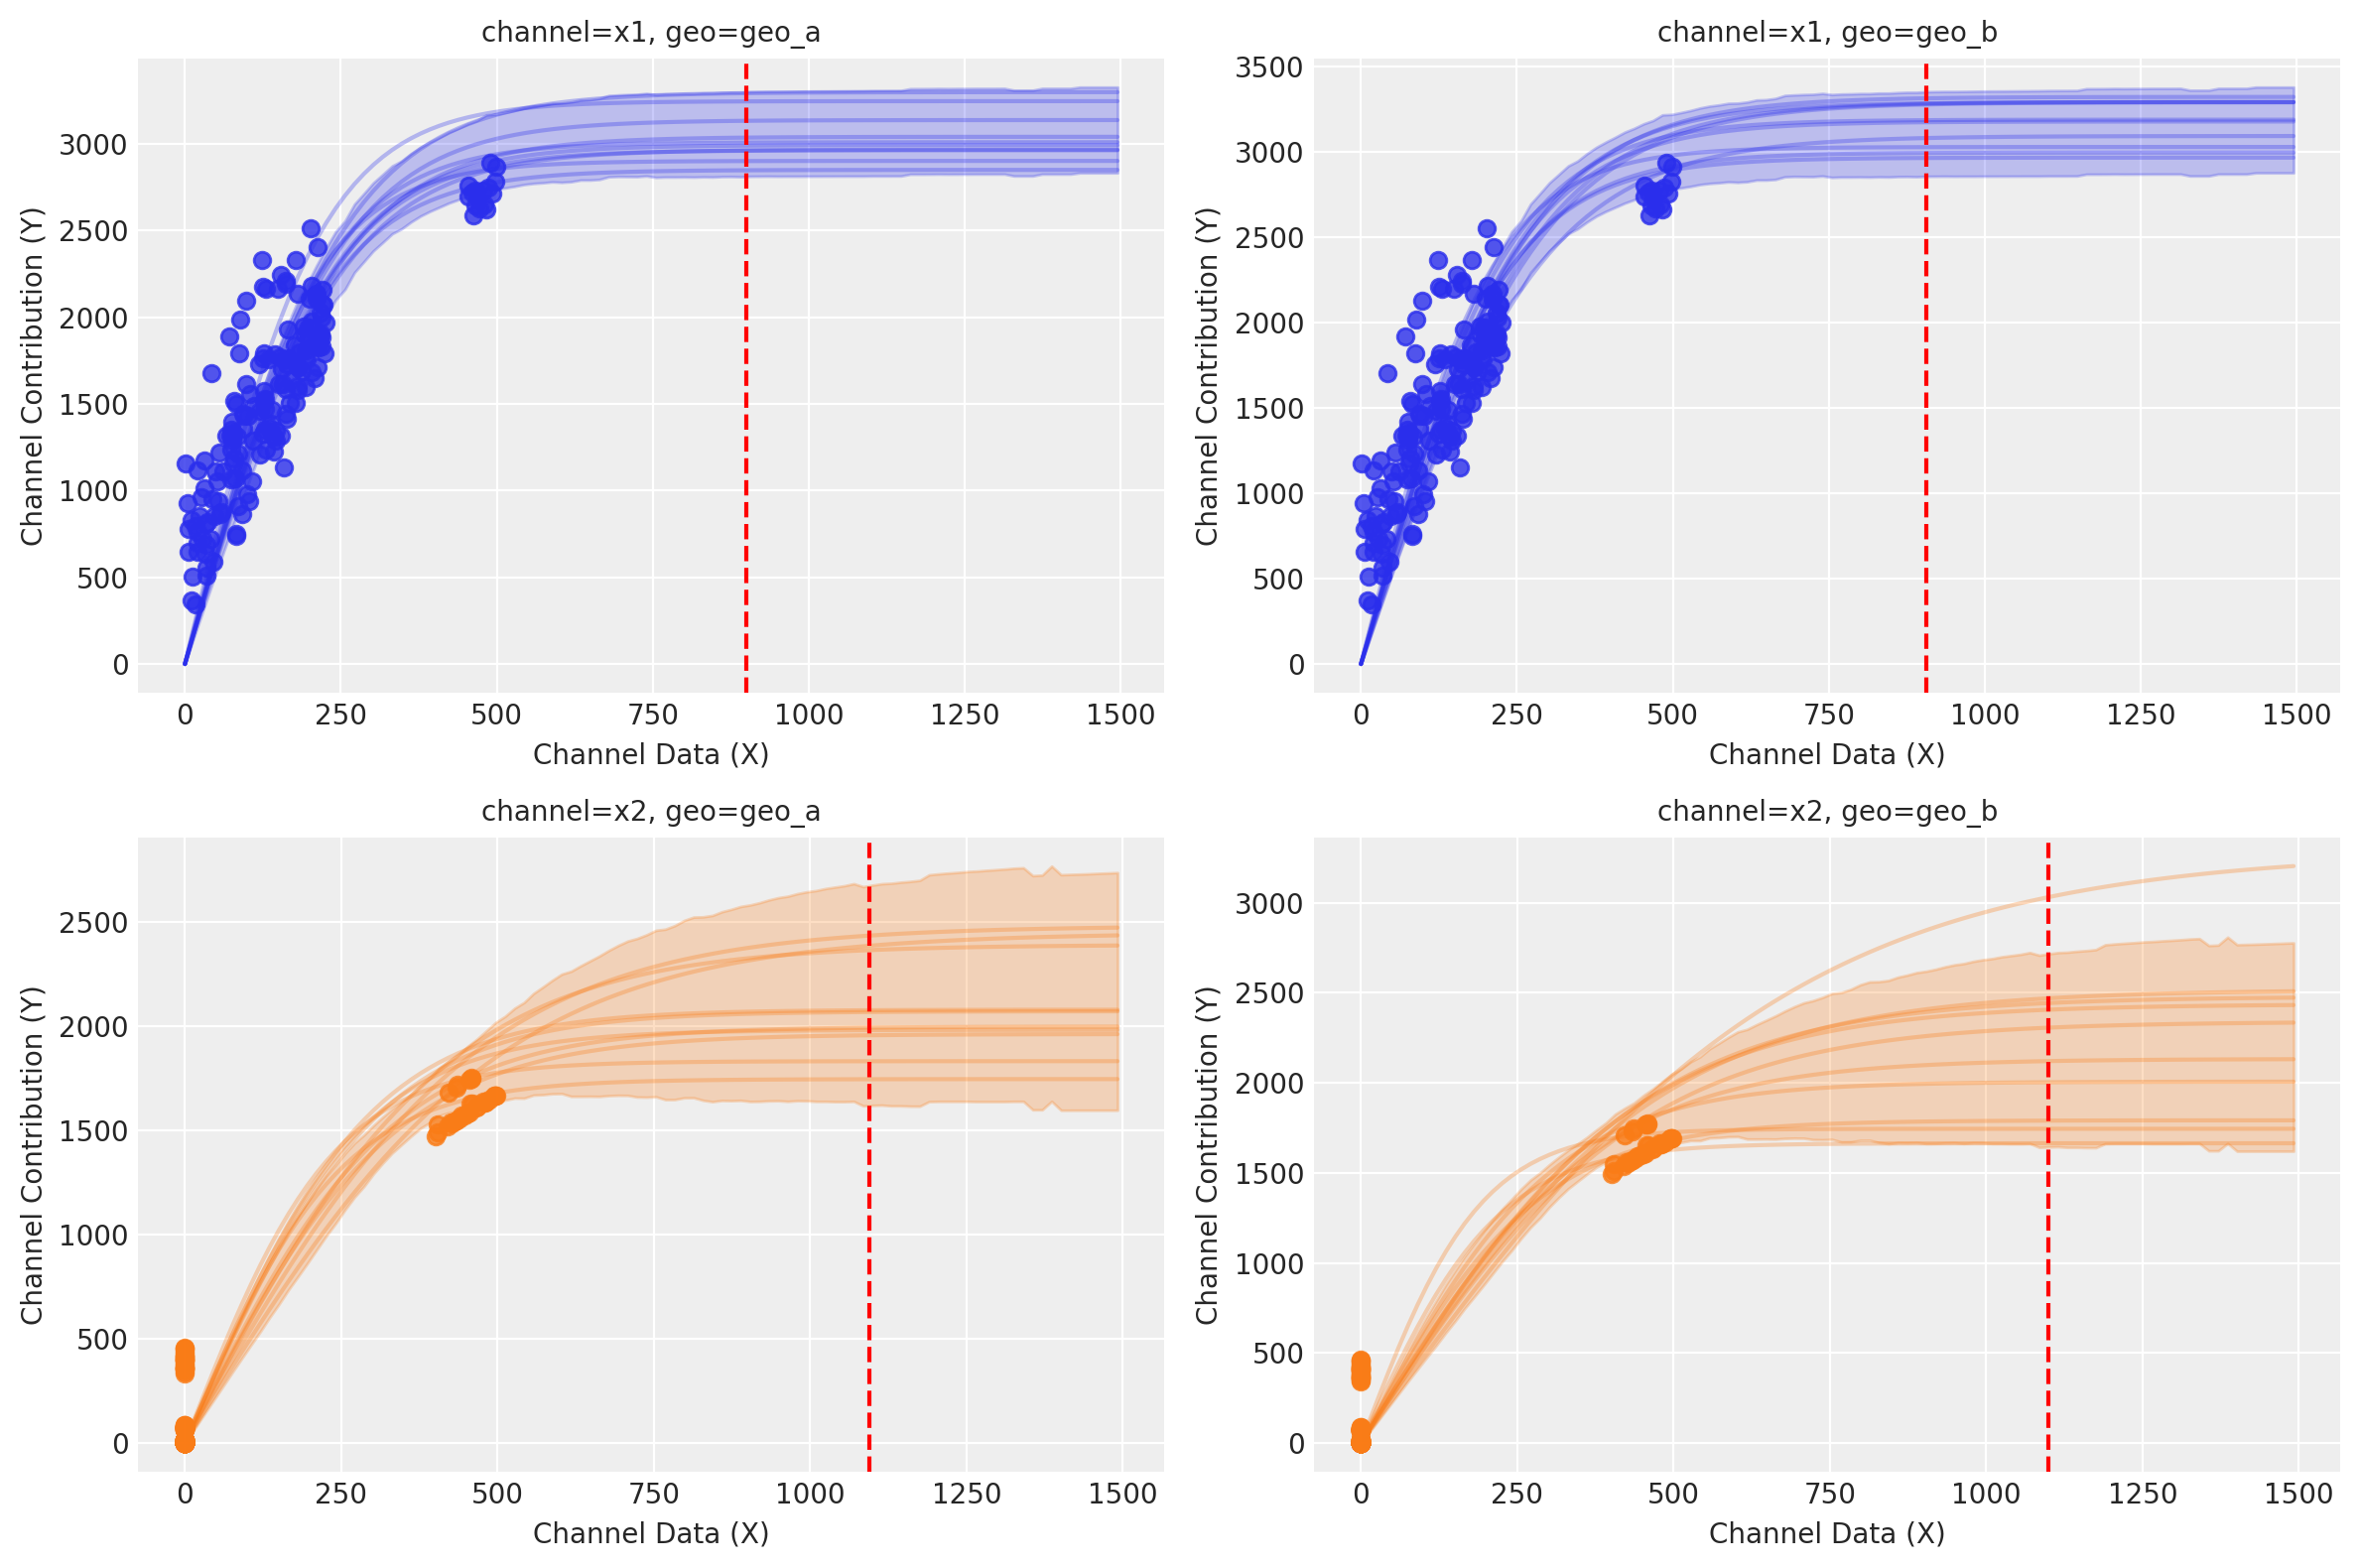

In [21]:
curve = mmm.saturation.sample_curve(
    mmm.idata.posterior[["saturation_beta", "saturation_lam"]], max_value=3
)
fig, axes = mmm.plot.saturation_curves(
    curve,
    original_scale=True,
    n_samples=10,
    hdi_probs=0.85,
    random_seed=rng,
    subplot_kwargs={"figsize": (12, 8), "ncols": 2},
    rc_params={
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "axes.labelsize": 10,
        "axes.titlesize": 10,
    },
)

# Add vertical lines for each geo-channel combo from the allocation
channels = sample_response_given_allocation.channel.values
geos = sample_response_given_allocation.geo.values

# Iterate over all channel-geo combinations
subplot_idx = 0
for channel in channels:
    for geo in geos:
        # Make sure we're accessing the correct axis object
        ax = axes.flat[subplot_idx] if isinstance(axes, np.ndarray) else axes

        # Get the budget value for this specific channel-geo combination
        budget_value = sample_response_given_allocation.allocation.sel(
            channel=channel, geo=geo
        ).item()

        # Add vertical line with a label
        ax.axvline(
            x=budget_value,
            color="red",
            linestyle="--",
            label=f"{channel}-{geo}: {budget_value:.1f}",
        )

        subplot_idx += 1

# Ensure we're working with actual axes objects, not numpy arrays
for i in range(len(channels) * len(geos)):
    ax = axes.flat[i] if isinstance(axes, np.ndarray) else axes
    if hasattr(ax, "title"):
        ax.title.set_fontsize(10)

if hasattr(fig, "_suptitle") and fig._suptitle is not None:
    fig._suptitle.set_fontsize(12)

plt.tight_layout()
plt.show()

As expected, the allocated budget lies into the saturation zone, meaning, we hae a little movement given the current spend. At least for some channels.

We can iterate over different budgets, adding a bit less or more and validate how much our response move forward given the additional budget.

Optimization for budget: 3200.00M


Sampling: [y]


Optimization for budget: 4000.00M


Sampling: [y]


Optimization for budget: 7200.00M


Sampling: [y]


Optimization for budget: 8800.00M


Sampling: [y]


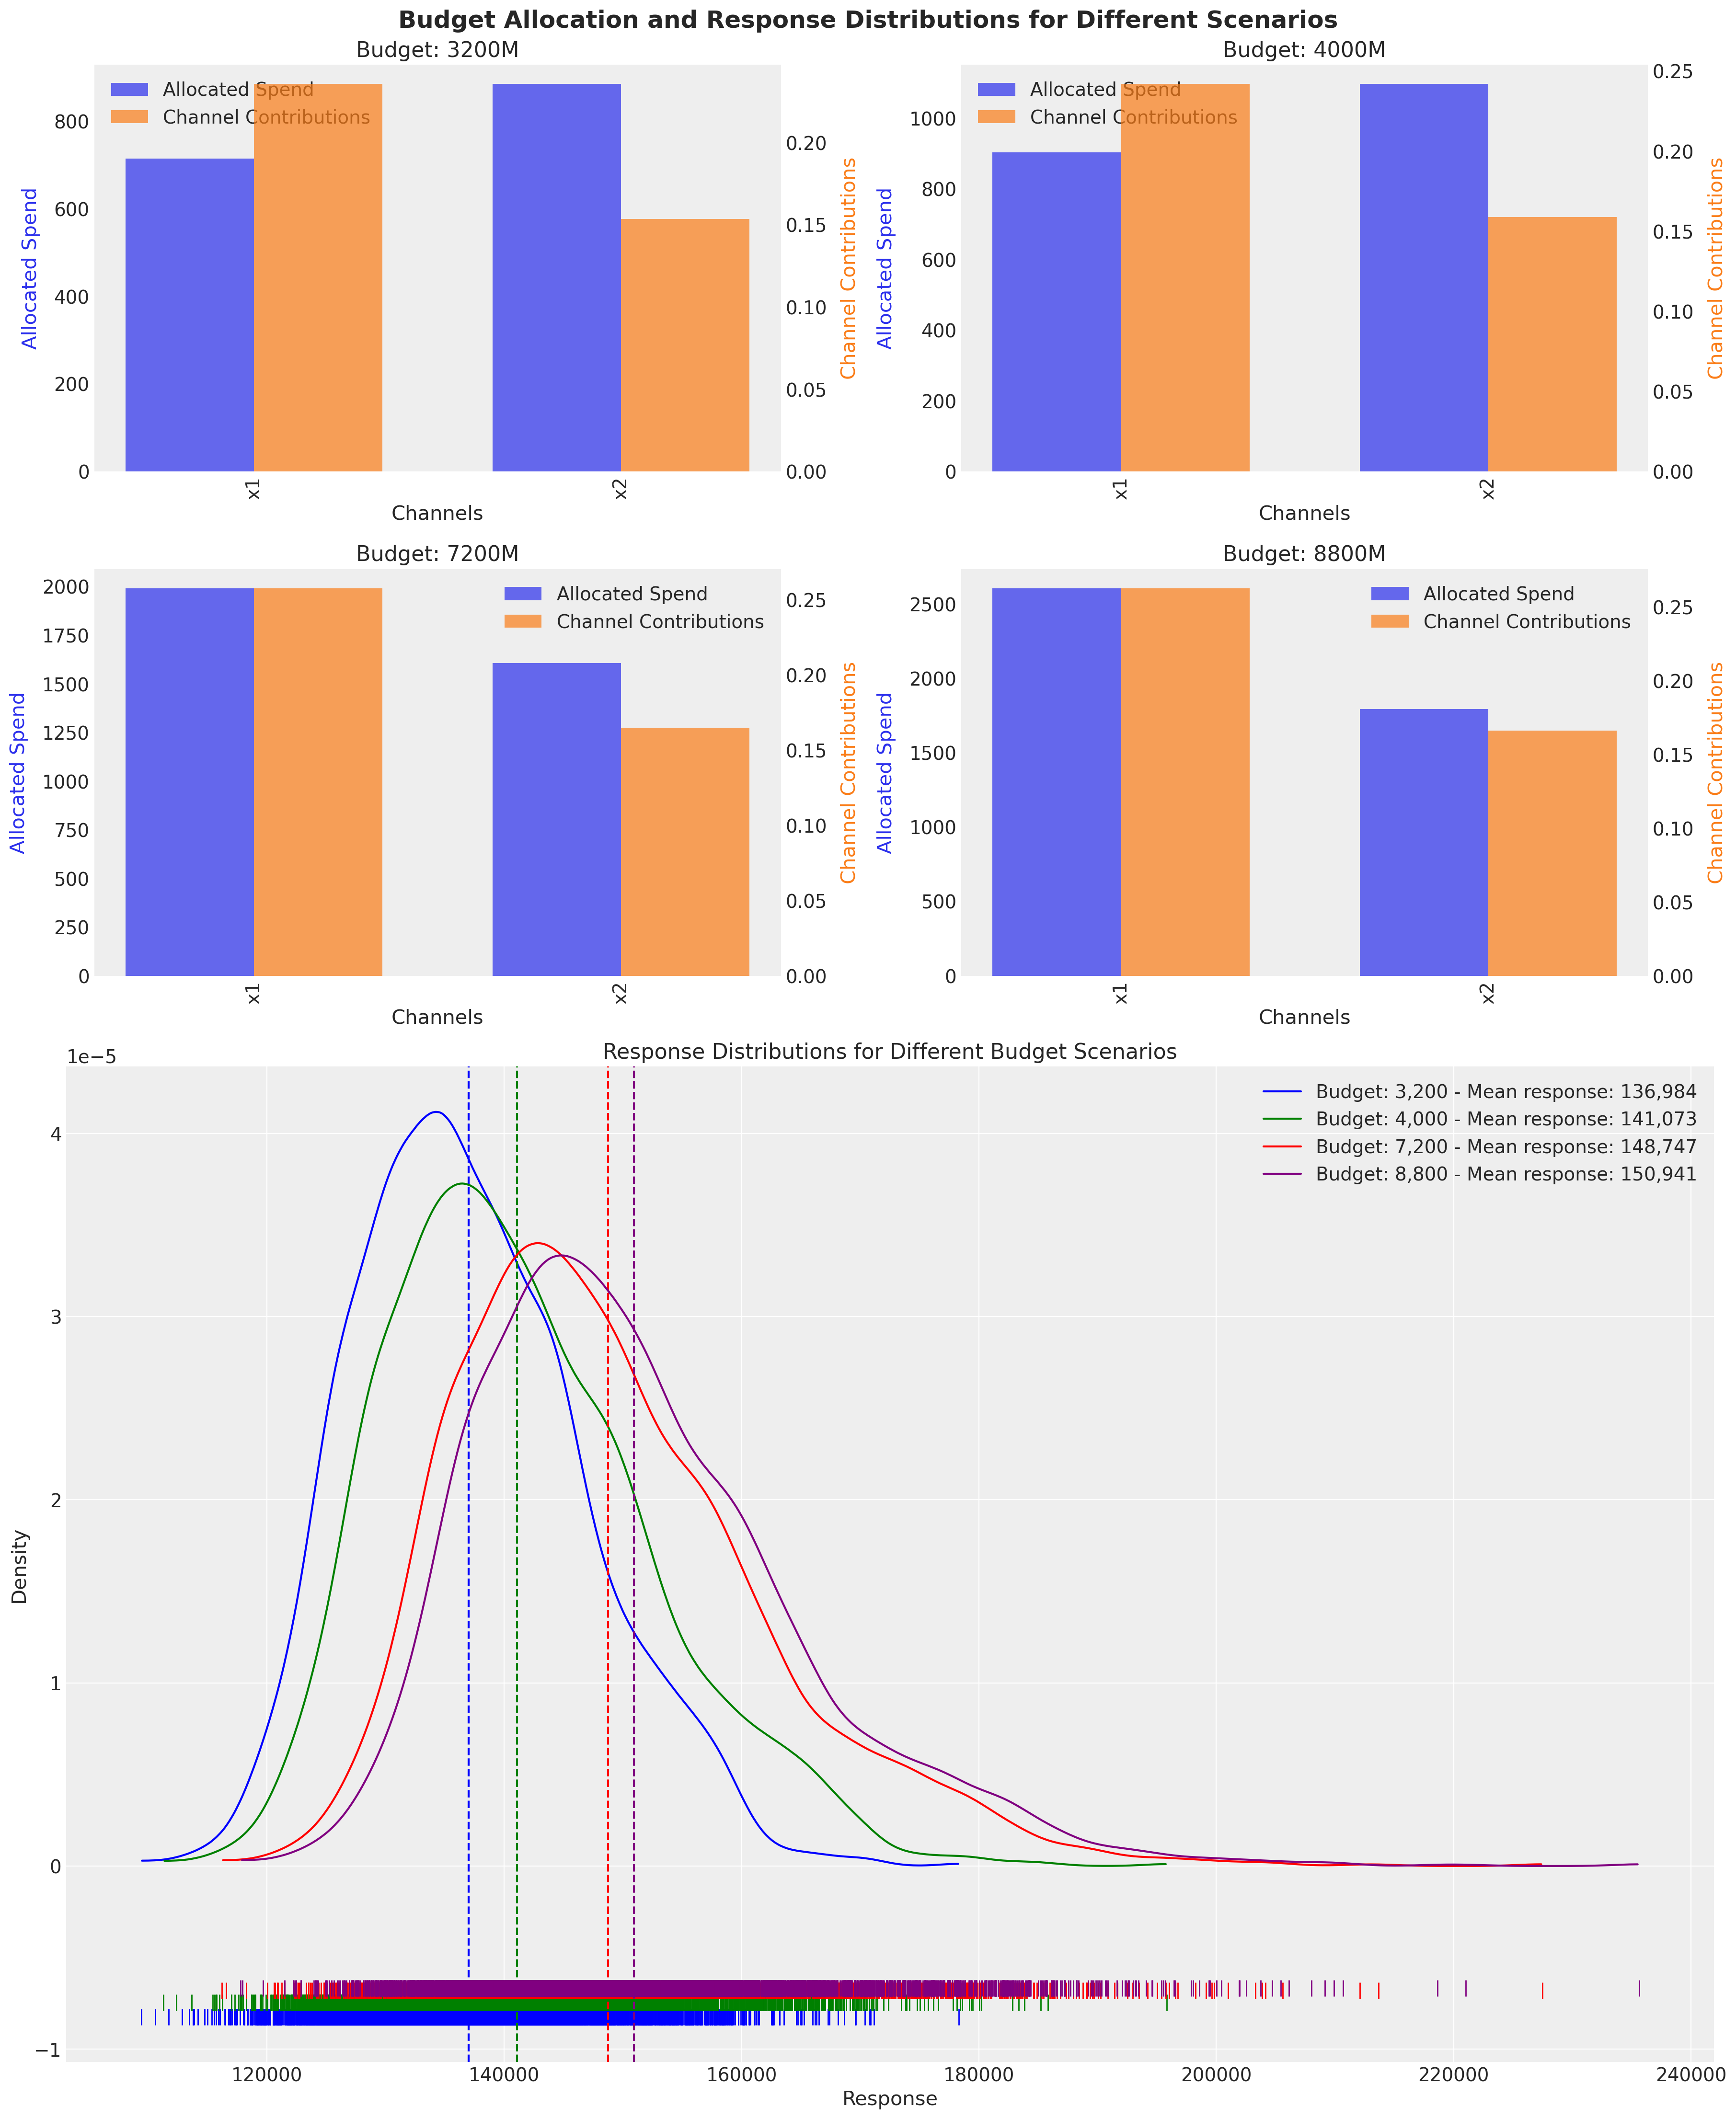

In [22]:
scenarios = np.array([0.8, 1, 1.8, 2.2])
colors = ["blue", "green", "red", "purple"]

# Create a larger figure with 2 rows
fig = plt.figure(figsize=(18, 22), layout="constrained")
gs = fig.add_gridspec(2, 1, height_ratios=[1, 1])

# Create a 2x2 grid for budget allocations in the top row
gs_top = gs[0].subgridspec(2, 2)

# Store responses and allocations for later use
responses = []
allocations = []

# Budget allocations in a 2x2 grid
for i, scenario in enumerate(scenarios):
    row, col = divmod(i, 2)  # Calculate row and column position in 2x2 grid

    tmp_budget = time_unit_budget * scenario
    print(f"Optimization for budget: {tmp_budget:.2f}M")
    tmp_allocation_strategy, tmp_optimization_result = (
        optimizable_model.optimize_budget(
            budget=tmp_budget,
        )
    )

    # Save allocation for later use
    allocations.append(tmp_allocation_strategy)

    tmp_response = optimizable_model.sample_response_distribution(
        allocation_strategy=tmp_allocation_strategy,
        include_carryover=True,
        include_last_observations=False,
    )
    # Save response for later use
    responses.append(tmp_response)

    # Add subplot for budget allocation in 2x2 grid
    ax = fig.add_subplot(gs_top[row, col])
    _, ax = optimizable_model.plot.budget_allocation(samples=tmp_response, ax=ax)
    ax.set_title(f"Budget: {tmp_budget:.0f}M")

# Second row: Response distributions (spanning the full width)
ax_dist = fig.add_subplot(gs[1])
for i, response in enumerate(responses):
    az.plot_dist(
        response.total_media_contribution_original_scale.values.flatten(),
        rug=True,
        color=colors[i],
        label=(
            f"Budget: {scenarios[i] * time_unit_budget:,.0f} - "
            f"Mean response: {response.total_media_contribution_original_scale.values.flatten().mean():,.0f}"
        ),
        ax=ax_dist,
    )

    # Add vertical line for mean
    mean_value = (
        response.total_media_contribution_original_scale.values.flatten().mean()
    )
    ax_dist.axvline(mean_value, color=colors[i], linestyle="--")

ax_dist.set_title("Response Distributions for Different Budget Scenarios")
ax_dist.set_xlabel("Response")
ax_dist.set_ylabel("Density")
ax_dist.legend()

fig.suptitle(
    "Budget Allocation and Response Distributions for Different Scenarios",
    fontsize=18,
    fontweight="bold",
);

This makes everything clear, even adding the double of budget we can't move to much our total response. **We are maximizing the response anyways but at what cost?** Lets take a look to the number of units back per unit spend, similar to ROAS.

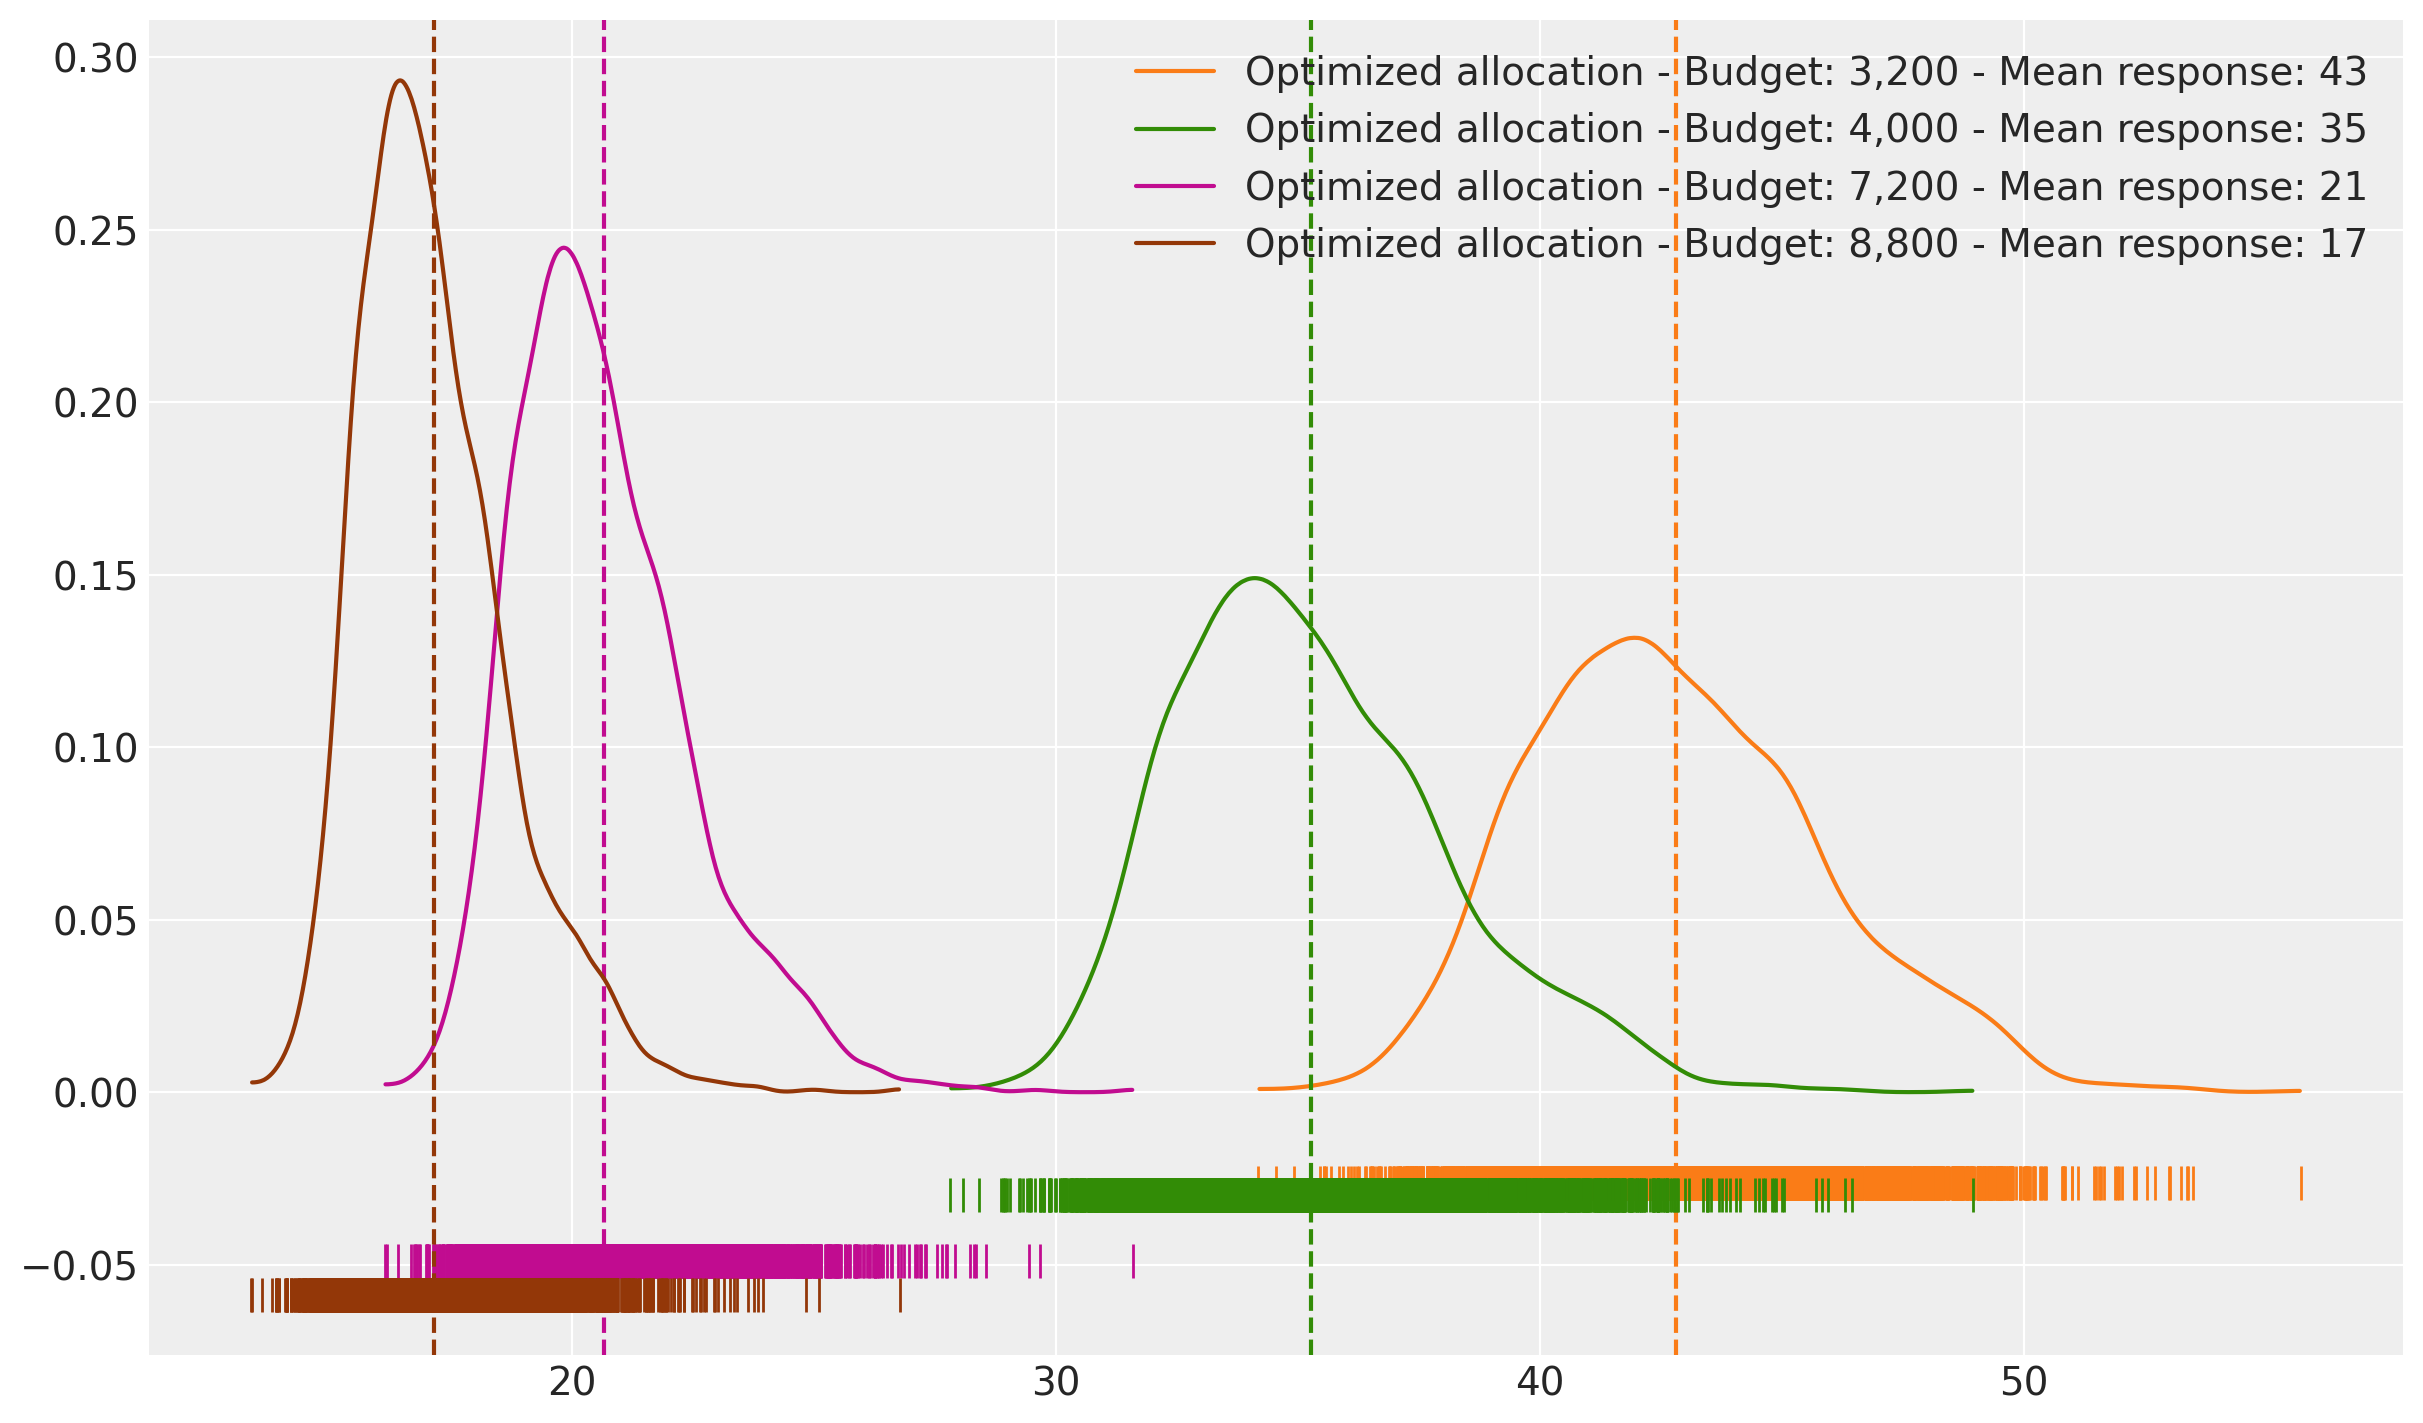

In [23]:
fig, ax = plt.subplots()

for index, response in enumerate(responses):
    optimized_data = (
        response.total_media_contribution_original_scale.values.flatten()
        / allocations[index].sum().item()
    )
    optimized_mean = optimized_data.mean()
    az.plot_dist(
        optimized_data,
        # hdi_prob=0.75,
        color=f"C{index + 1}",
        label=(
            f"Optimized allocation - Budget: {scenarios[index] * time_unit_budget:,.0f} - "
            f"Mean response: {optimized_data.mean():,.0f}"
        ),
        ax=ax,
        rug=True,
        # kind="hist",
    )
    ax.axvline(optimized_mean, color=f"C{index + 1}", linestyle="--")

As expected, bigger the budget lower the returns. This happens because the response it's similar but the budget increase faster than our response (Yes, the diminishing return effect).

We can ask a different question, if we want to get 145,000 then whats the cheaper way to make it?

## Optimizing towards a target
Another way to approach optimization is to adjust towards a target response. This can be useful if you want to ensure that the response is above a certain level. Instead of optimize a given budget, we can optimize find the right budget to reach a target response.

The following example shows how to create a custom constraint to minimize the budget to reach a target response. In short words, we are asking to the optimizer, what't the minimum budget to reach a certain response?

In [24]:
import pytensor.tensor as pt

from pymc_marketing.mmm.budget_optimizer import BudgetOptimizer
from pymc_marketing.mmm.constraints import Constraint
from pymc_marketing.mmm.utility import _check_samples_dimensionality

target_response = 145_000


def mean_response_eq_constraint_fun(budgets_sym, total_budget_sym, optimizer):
    """Enforces mean_response(budgets_sym) = target_response, i.e. returns (mean_resp - target_response)."""
    resp_dist = optimizer.extract_response_distribution(
        "total_media_contribution_original_scale"
    )
    mean_resp = pt.mean(_check_samples_dimensionality(resp_dist))
    return mean_resp - target_response


def minimize_budget_utility(samples, budgets):
    return -pt.sum(budgets)


optimizer = BudgetOptimizer(
    num_periods=campaign_period,
    model=optimizable_model,
    response_variable="total_media_contribution_original_scale",
    utility_function=minimize_budget_utility,
    default_constraints=False,
    custom_constraints=[
        Constraint(
            key="target_response_constraint",
            constraint_fun=mean_response_eq_constraint_fun,
            constraint_type="eq",
        )
    ],
)

allocation_xarray_target_response, res = optimizer.allocate_budget(
    total_budget=time_unit_budget // 2,
    x0=res_scipy.x,
    minimize_kwargs={"options": {"maxiter": 2_000}},
    budget_bounds=budget_bounds,
)

print("Optimal allocation:", allocation_xarray_target_response)
print("Solver result:", res)

Optimal allocation: <xarray.DataArray (geo: 2, channel: 2)> Size: 32B
array([[1372.49659691, 1236.01094652],
       [1390.45846735, 1243.4769769 ]])
Coordinates:
  * geo      (geo) <U5 40B 'geo_a' 'geo_b'
  * channel  (channel) <U2 16B 'x1' 'x2'
Solver result:      message: Optimization terminated successfully
     success: True
      status: 0
         fun: 5242.442987676456
           x: [ 1.372e+03  1.236e+03  1.390e+03  1.243e+03]
         nit: 33
         jac: [ 1.000e+00  1.000e+00  1.000e+00  1.000e+00]
        nfev: 34
        njev: 33
 multipliers: [ 4.085e-01]


In [25]:
sample_response_given_allocation_target_response = (
    optimizable_model.sample_response_distribution(
        allocation_strategy=allocation_xarray_target_response,
        include_carryover=True,
        include_last_observations=False,
    )
)

Sampling: [y]


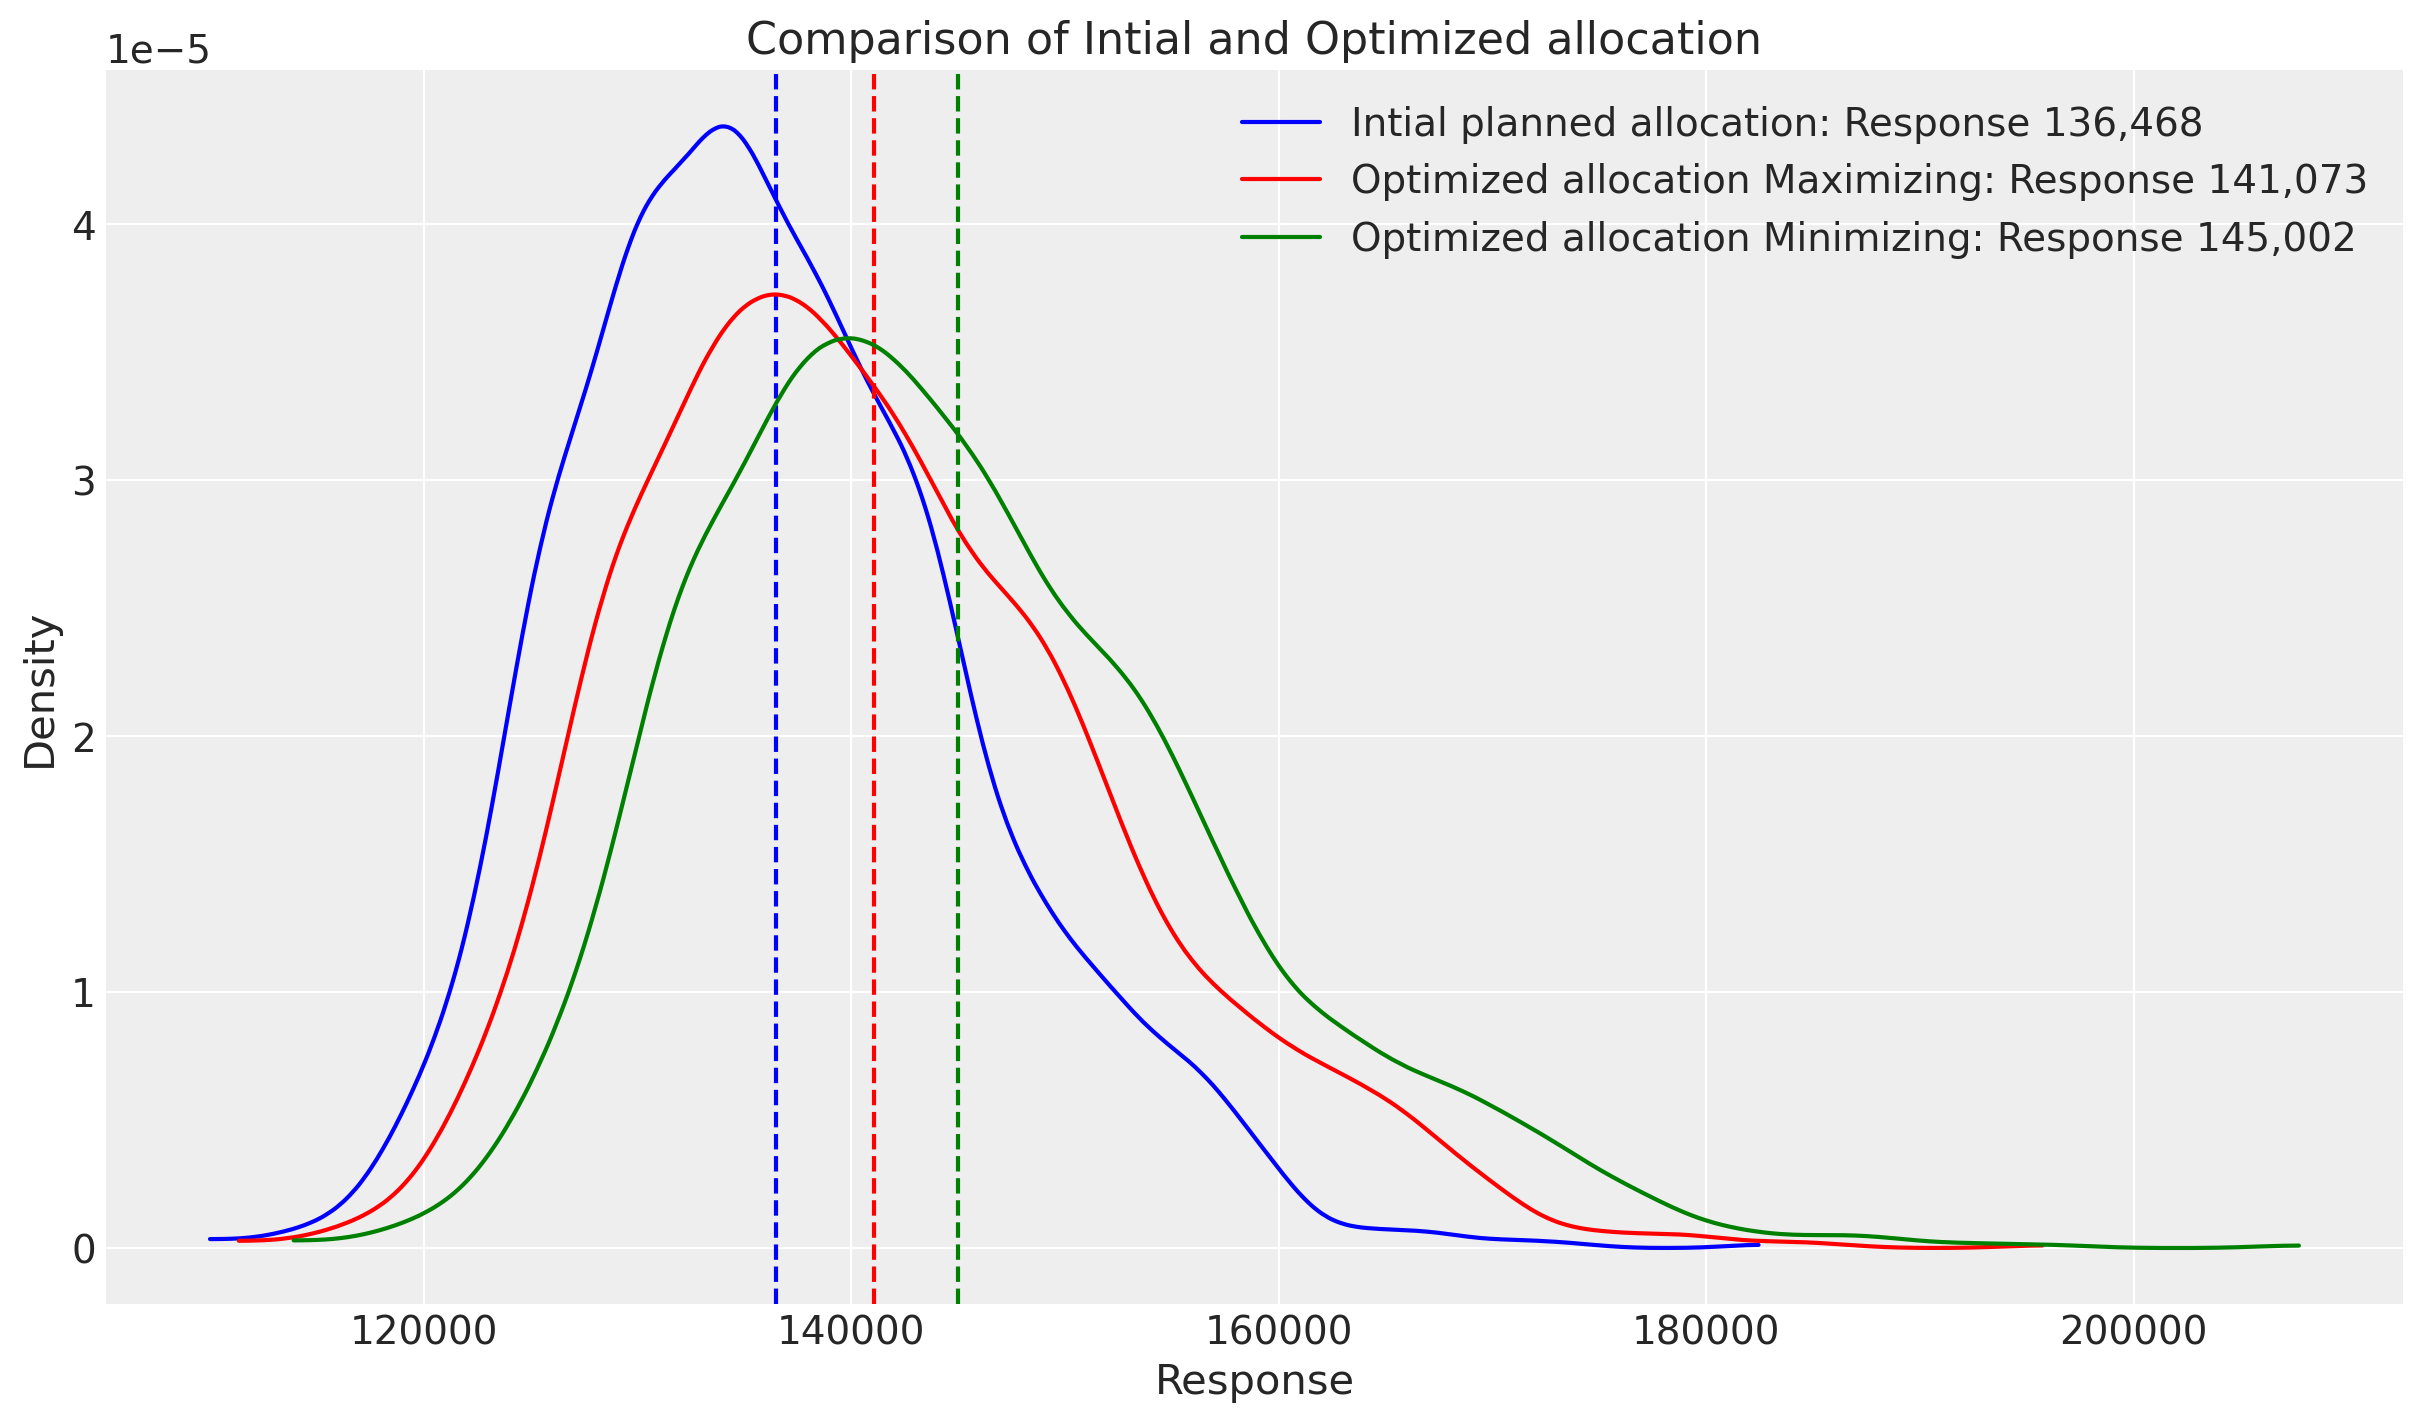

In [26]:
fig, ax = plt.subplots()

# Initial planned allocation
initial_data = sample_response_give_initial_budget.total_media_contribution_original_scale.values.flatten()
initial_mean = initial_data.mean()
az.plot_dist(
    initial_data,
    # hdi_prob=0.75,
    color="blue",
    label=f"Intial planned allocation: Response {initial_mean:,.0f}",
    ax=ax,
    # kind="hist",
)
ax.axvline(initial_mean, color="blue", linestyle="--")

# Optimized allocation based on maximizing the response
optimized_data = sample_response_given_allocation.total_media_contribution_original_scale.values.flatten()
optimized_mean = optimized_data.mean()
az.plot_dist(
    optimized_data,
    # hdi_prob=0.75,
    color="red",
    label=f"Optimized allocation Maximizing: Response {optimized_mean:,.0f}",
    ax=ax,
    # kind="hist",
)
ax.axvline(optimized_mean, color="red", linestyle="--")

# Optimized allocation based on minimizing the budget
optimized_data_target_response = sample_response_given_allocation_target_response.total_media_contribution_original_scale.values.flatten()  # noqa: E501
optimized_mean_target_response = optimized_data_target_response.mean()
az.plot_dist(
    optimized_data_target_response,
    # hdi_prob=0.75,
    color="green",
    label=f"Optimized allocation Minimizing: Response {optimized_mean_target_response:,.0f}",
    ax=ax,
    # kind="hist",
)
ax.axvline(optimized_mean_target_response, color="green", linestyle="--")

ax.set_title("Comparison of Intial and Optimized allocation")
ax.set_xlabel("Response")
ax.set_ylabel("Density")
ax.legend()

plt.show()

Great, looks like using 5$ euros, we could get a response even bigger than the initial optimization. Considering that the spend it's slightly more in order to get this amount of response, ROAS should be good. Let's take a look!

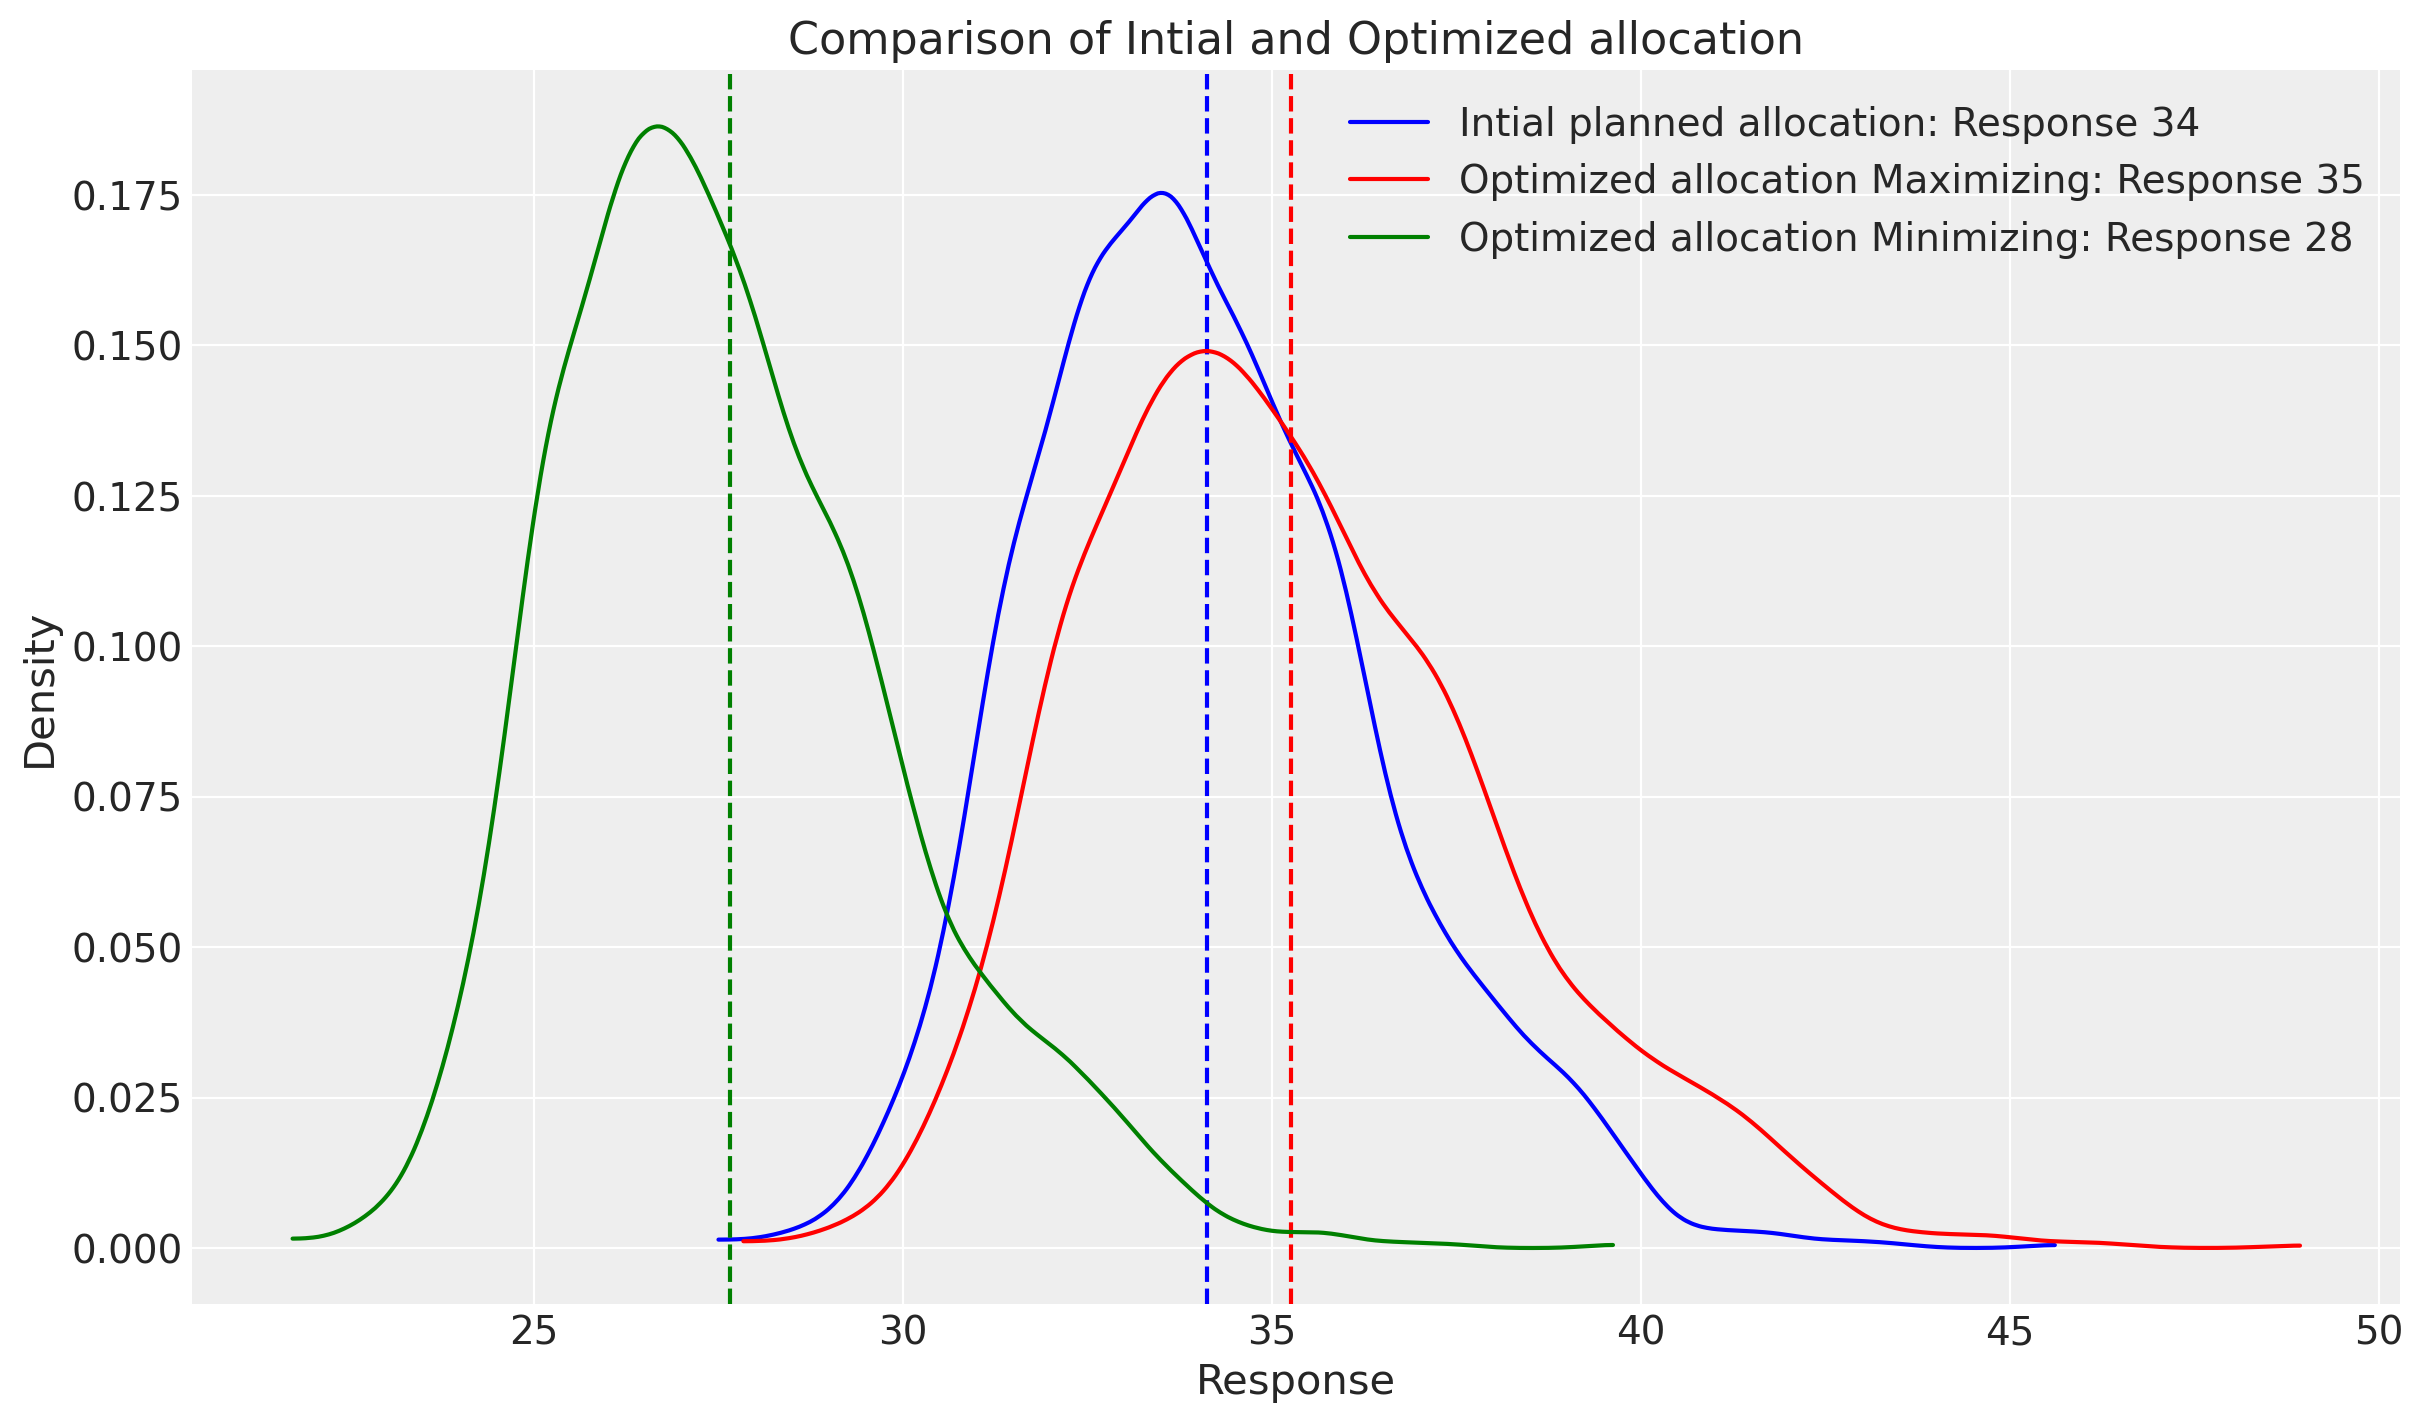

In [27]:
fig, ax = plt.subplots()

# Initial planned allocation
initial_data = (
    sample_response_give_initial_budget.total_media_contribution_original_scale.values.flatten()
    / initial_budget.sum().item()
)
initial_mean = initial_data.mean()
az.plot_dist(
    initial_data,
    # hdi_prob=0.75,
    color="blue",
    label=f"Intial planned allocation: Response {initial_mean:,.0f}",
    ax=ax,
    # kind="hist",
)
ax.axvline(initial_mean, color="blue", linestyle="--")

# Optimized allocation based on maximizing the response
optimized_data = (
    sample_response_given_allocation.total_media_contribution_original_scale.values.flatten()
    / allocation_xarray.sum().item()
)
optimized_mean = optimized_data.mean()
az.plot_dist(
    optimized_data,
    # hdi_prob=0.75,
    color="red",
    label=f"Optimized allocation Maximizing: Response {optimized_mean:,.0f}",
    ax=ax,
    # kind="hist",
)
ax.axvline(optimized_mean, color="red", linestyle="--")

# Optimized allocation based on minimizing the budget
optimized_data_target_response = (
    sample_response_given_allocation_target_response.total_media_contribution_original_scale.values.flatten()
    / allocation_xarray_target_response.sum().item()
)
optimized_mean_target_response = optimized_data_target_response.mean()
az.plot_dist(
    optimized_data_target_response,
    # hdi_prob=0.75,
    color="green",
    label=f"Optimized allocation Minimizing: Response {optimized_mean_target_response:,.0f}",
    ax=ax,
    # kind="hist",
)
ax.axvline(optimized_mean_target_response, color="green", linestyle="--")

ax.set_title("Comparison of Intial and Optimized allocation")
ax.set_xlabel("Response")
ax.set_ylabel("Density")
ax.legend()

plt.show()

The new result is much clearer. By using a bit more budget, we could achieve the more outcomes as our initial setup, in a more profitable way. On the other hand, the optimal allocation distributes the budget in levels similar by the model, not increasing the uncertainty around the estimated impact, at least not as much as going up a 2X more on budget.

Please note that the estimate provided assumes consistent spending each week. However, in the field of marketing, even with a fixed spending level, the actual spending can fluctuate based on factors such as the number of people bidding on your ad or viewing ads on a given day.

To account for this unpredictable variation, we have included a parameter called `noise_level` that allows you to introduce white noise into the projection. This can provide a sense of what the outcome might look like if the recommended budget could potentially fluctuate by a certain extent. The default value for `noise_level` is 1%, but you can adjust it as needed. In the example below, we have used a value of 10%.

Take a look to signature below!

In [28]:
optimizable_model.sample_response_distribution?

Signature:
optimizable_model.sample_response_distribution(
    allocation_strategy: 'xr.DataArray',
    noise_level: 'float' = 0.001,
    additional_var_names: 'list[str] | None' = None,
    include_last_observations: 'bool' = True,
    include_carryover: 'bool' = True,
    budget_distribution_over_period: 'xr.DataArray | None' = None,
) -> 'az.InferenceData'
Docstring:
Generate synthetic dataset and sample posterior predictive based on allocation.

Parameters
----------
allocation_strategy : DataArray
    The allocation strategy for the channels.
noise_level : float
    The relative level of noise to add to the data allocation.
additional_var_names : list[str] | None
    Additional variable names to include in the posterior predictive sampling.
include_last_observations : bool
    Whether to include the last observations for continuity.
include_carryover : bool
    Whether to include carryover effects.
budget_distribution_over_period : xr.DataArray | None
    Distribution factors for 

If you don't want to assume a evenly distributed allocation given, you can use a custom pattern. Providing the optimizer a way around how to spend the money over time. The parameter it's call `budget_distribution_over_period` and you can read about it in the following signature.

In [29]:
optimizer?

Type:           BudgetOptimizer
String form:    num_periods=12 mmm_model=<pymc_marketing.mmm.multidimensional.MultiDimensionalBudgetOptimizerWrap <...> Constraint object at 0x348c4ff20>] default_constraints=False budget_distribution_over_period=None
File:           ~/Documents/GitHub/pymc-marketing/pymc_marketing/mmm/budget_optimizer.py
Docstring:     
A class for optimizing budget allocation in a marketing mix model.

The goal of this optimization is to maximize the total expected response
by allocating the given budget across different marketing channels. The
optimization is performed using the Sequential Least Squares Quadratic
Programming (SLSQP) method, which is a gradient-based optimization algorithm
suitable for solving constrained optimization problems.

For more information on the SLSQP algorithm, refer to the documentation:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

Parameters
----------
num_periods : int
    Number of time units at the

In [30]:
# Get dimensions from the sample response
dates = sample_response_give_initial_budget.date.values
geos = sample_response_give_initial_budget.geo.values
channels = ["x1", "x2"]

# Create decreasing values for each date that sum to 1
n_dates = len(dates)
decreasing_values = np.linspace(0.5, 0, n_dates)
# Normalize to make the sum equal to 1
decreasing_values = decreasing_values / decreasing_values.sum()

# Create the data array with the specified dimensions
data = np.zeros((len(dates), len(geos), len(channels)))
for i in range(len(geos)):
    for j in range(len(channels)):
        data[:, i, j] = decreasing_values

# Create xarray DataArray with proper dimensions
custom_budget_distribution = xr.DataArray(
    data,
    dims=["date", "geo", "channel"],
    coords={"date": dates, "geo": geos, "channel": channels},
)

> Note:
When using a custom budget distribution over time, ensure that the values for each channel and geo sum to 1 across the time dimension. This is demonstrated in the example above where we create decreasing values that are normalized to sum to 1.

In [31]:
custom_budget_distribution.sum(dim="date")

<xarray.DataArray (geo: 2, channel: 2)> Size: 32B
array([[1., 1.],
       [1., 1.]])
Coordinates:
  * geo      (geo) <U5 40B 'geo_a' 'geo_b'
  * channel  (channel) <U2 16B 'x1' 'x2'

We can pass this new parameter in the optimizable model.

In [32]:
allocation_xarray_custom_budget_distribution, _ = optimizable_model.optimize_budget(
    budget=time_unit_budget,  # Total budget to allocate here
    budget_distribution_over_period=custom_budget_distribution,
    minimize_kwargs={"options": {"maxiter": 2_000}},
    budget_bounds=budget_bounds,
)

sample_response_given_allocation_custom_budget_distribution = (
    optimizable_model.sample_response_distribution(
        allocation_strategy=allocation_xarray_custom_budget_distribution,
        include_carryover=True,
        include_last_observations=False,
        budget_distribution_over_period=custom_budget_distribution,
    )
)

Sampling: [y]


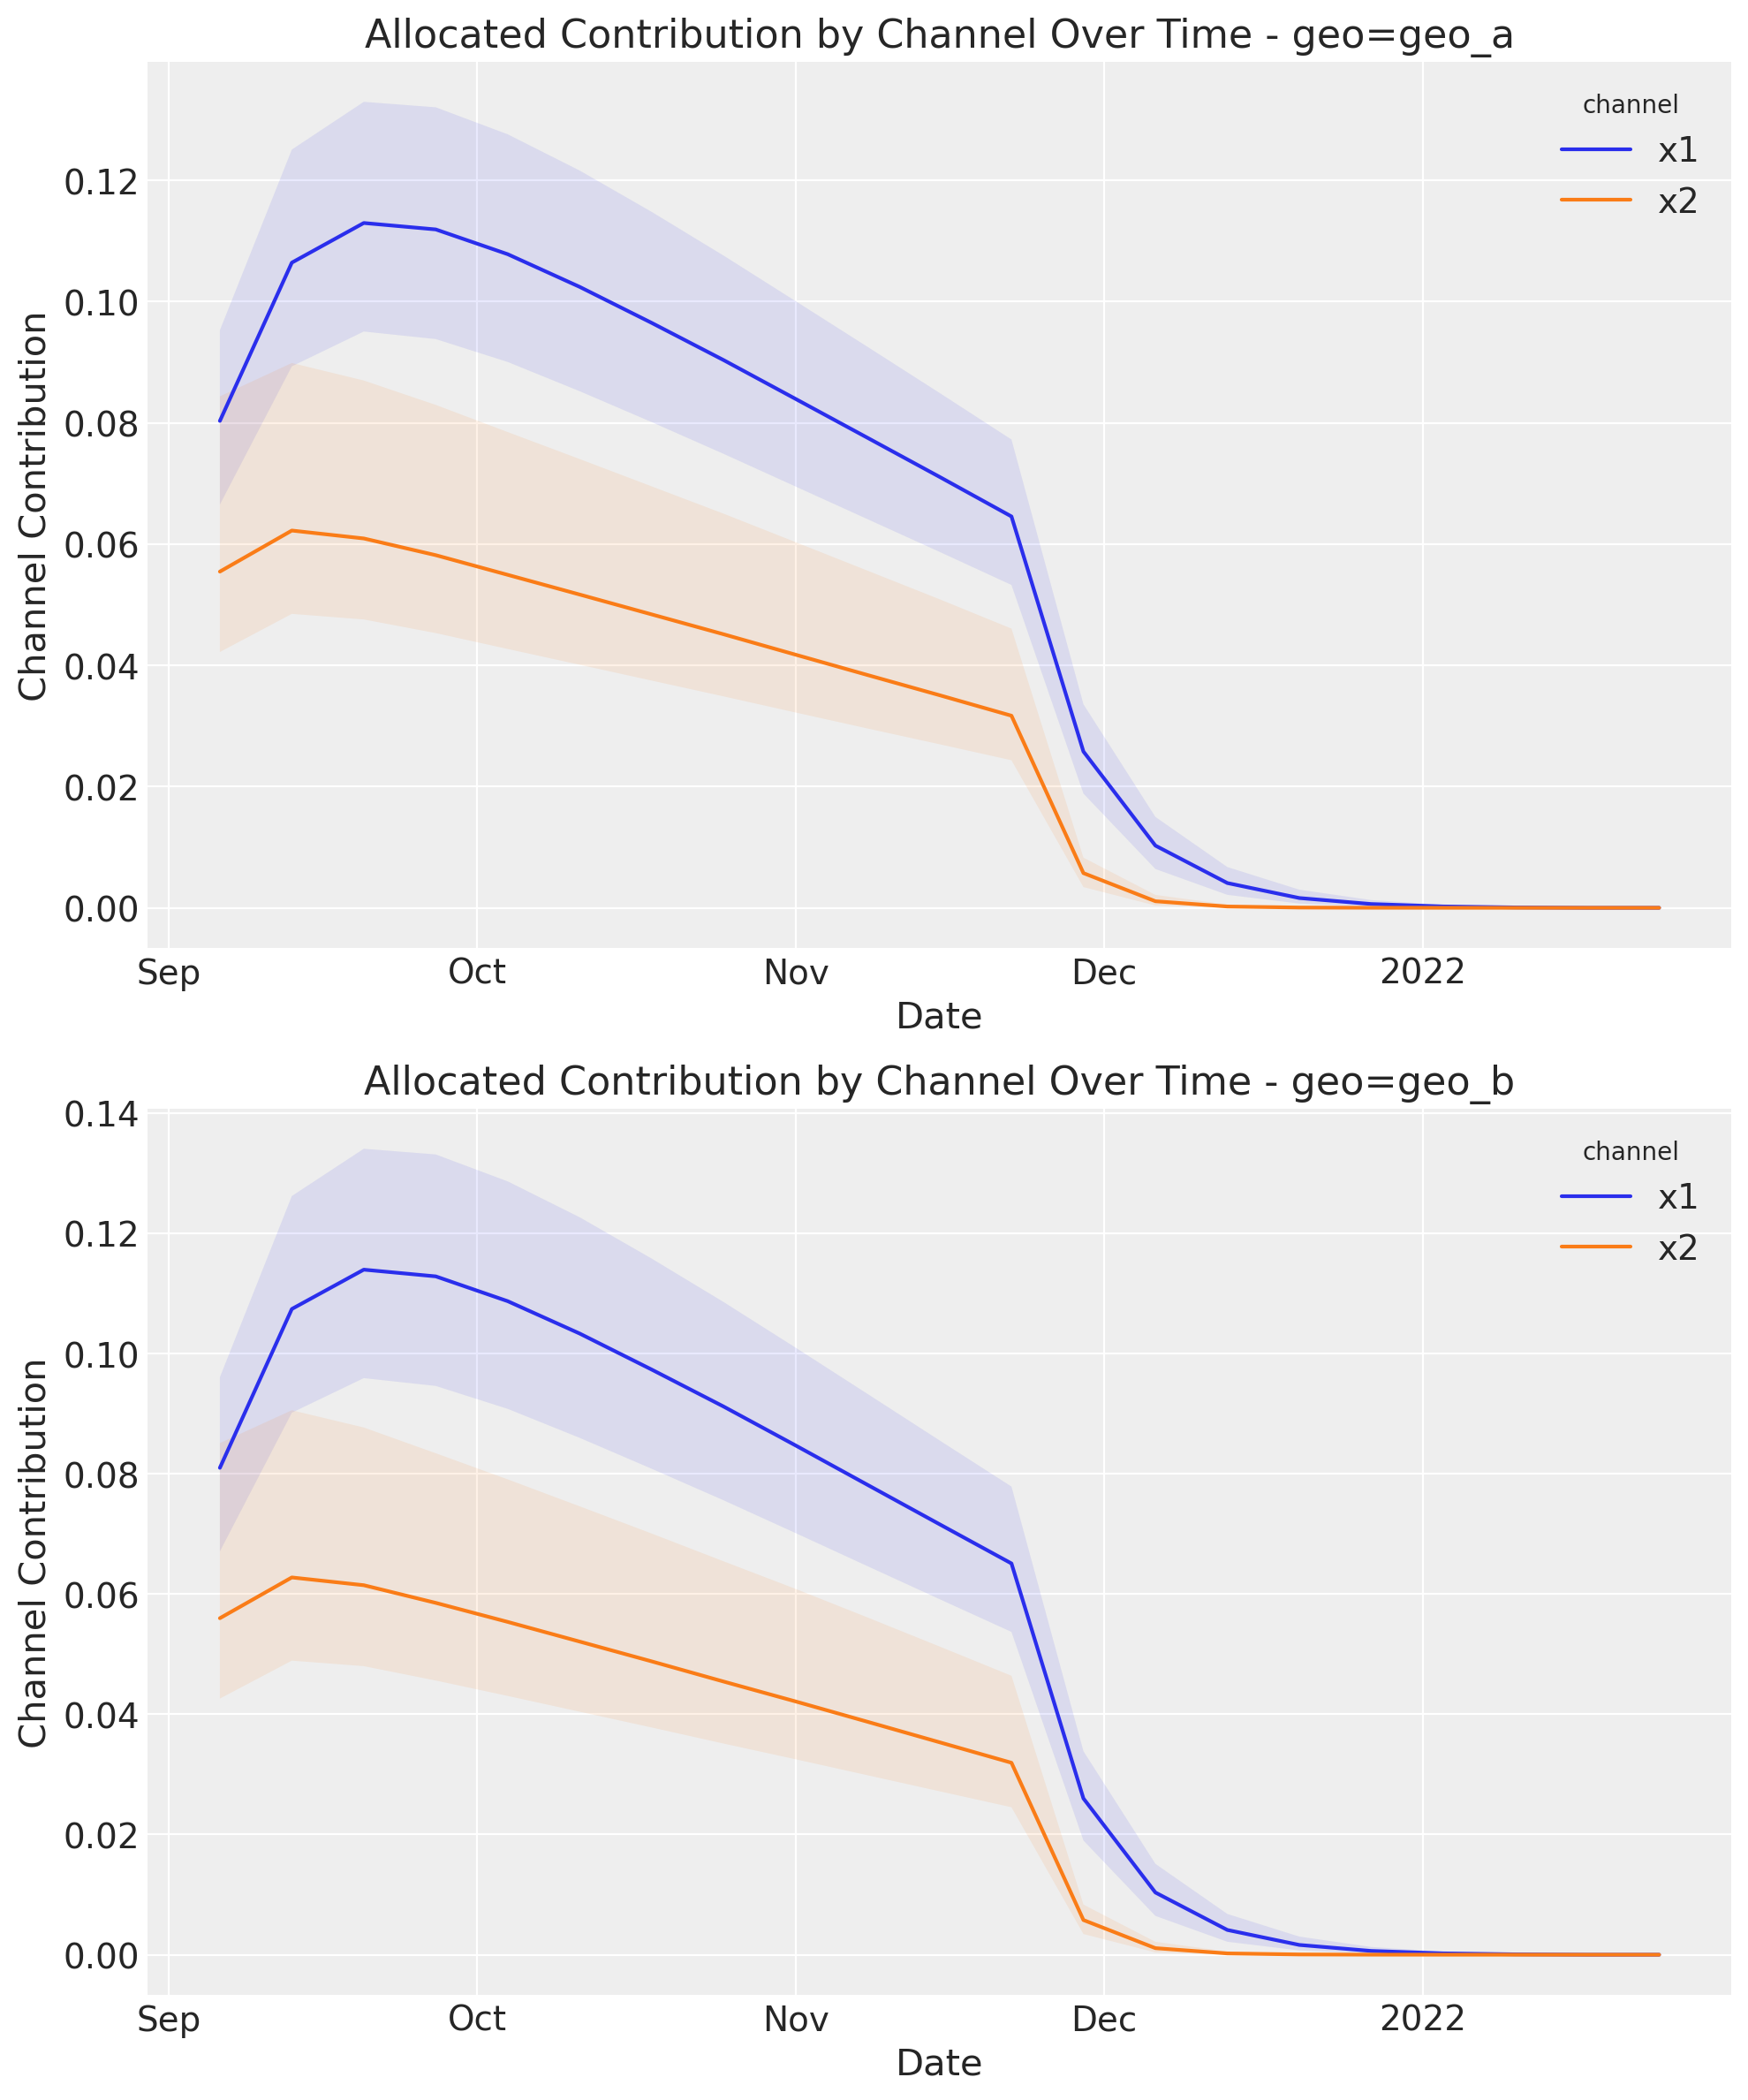

In [33]:
optimizable_model.plot.allocated_contribution_by_channel_over_time(
    samples=sample_response_given_allocation_custom_budget_distribution,
);

As expected, now the spend follows a specific pattern of spend, and the optimization process considers this as well. This change, can affect quite radically the total response, adding more or less complexity to your optimization challenges.

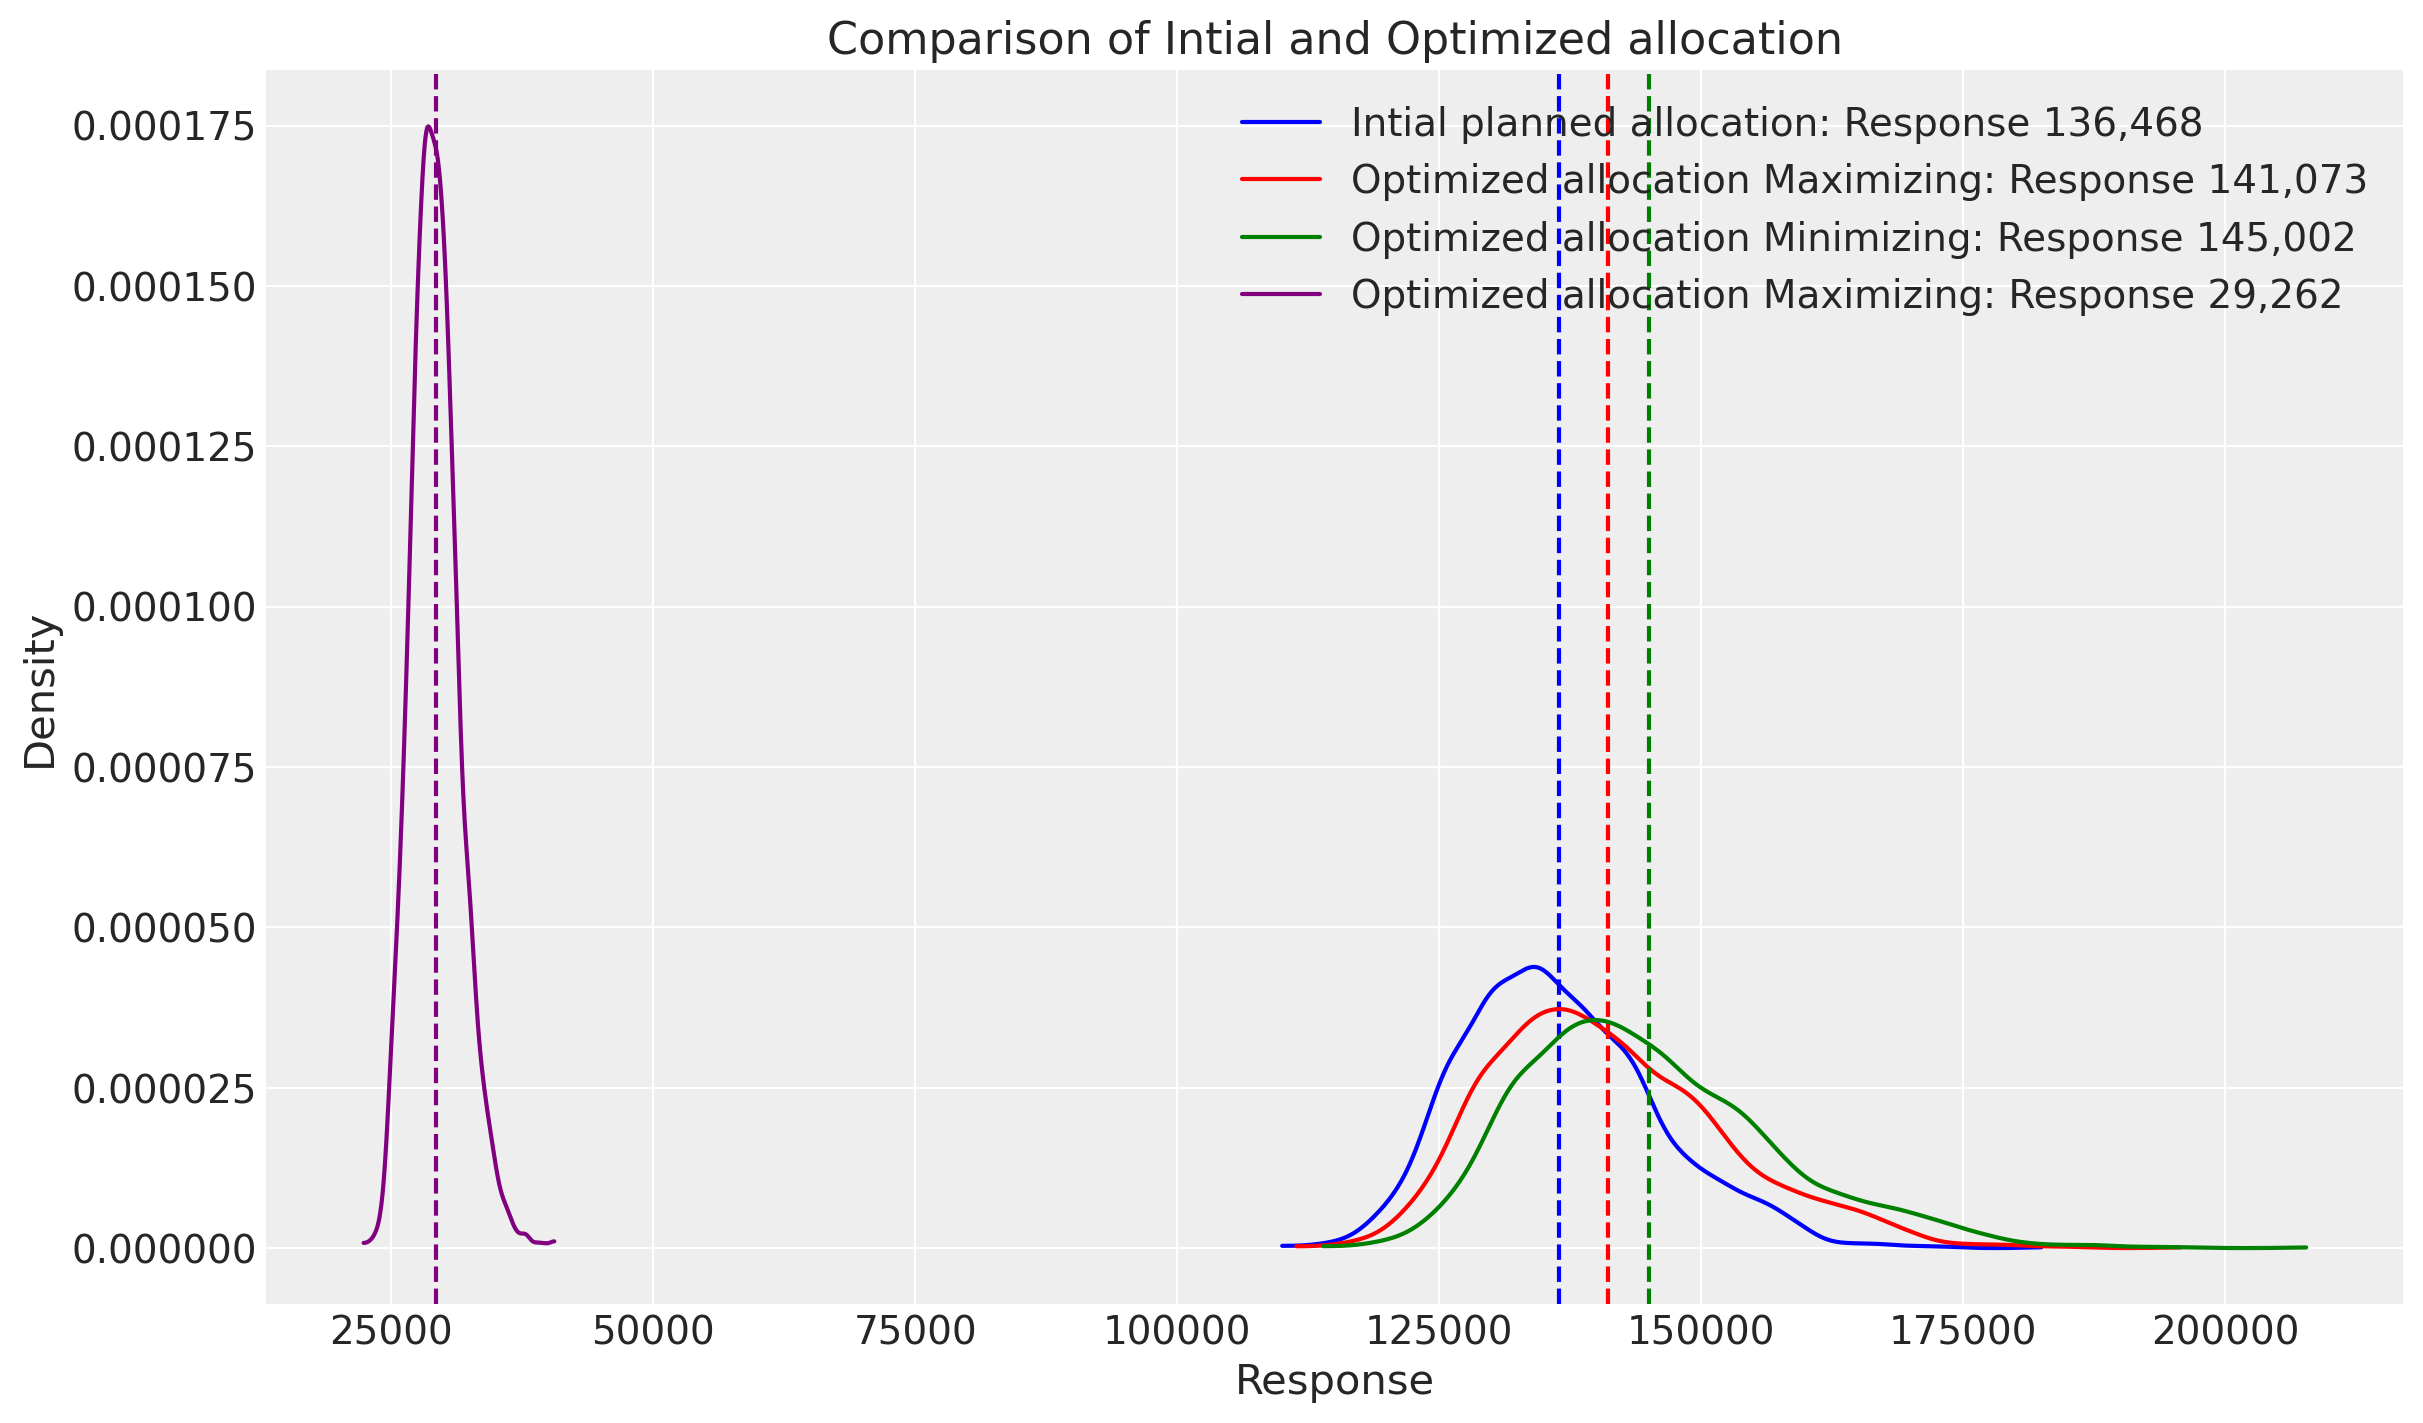

In [34]:
fig, ax = plt.subplots()

# Initial planned allocation
initial_data = sample_response_give_initial_budget.total_media_contribution_original_scale.values.flatten()
initial_mean = initial_data.mean()
az.plot_dist(
    initial_data,
    # hdi_prob=0.75,
    color="blue",
    label=f"Intial planned allocation: Response {initial_mean:,.0f}",
    ax=ax,
    # kind="hist",
)
ax.axvline(initial_mean, color="blue", linestyle="--")

# Optimized allocation based on maximizing the response
optimized_data = sample_response_given_allocation.total_media_contribution_original_scale.values.flatten()
optimized_mean = optimized_data.mean()
az.plot_dist(
    optimized_data,
    # hdi_prob=0.75,
    color="red",
    label=f"Optimized allocation Maximizing: Response {optimized_mean:,.0f}",
    ax=ax,
    # kind="hist",
)
ax.axvline(optimized_mean, color="red", linestyle="--")

# Optimized allocation based on minimizing the budget
optimized_data_target_response = sample_response_given_allocation_target_response.total_media_contribution_original_scale.values.flatten()  # noqa: E501
optimized_mean_target_response = optimized_data_target_response.mean()
az.plot_dist(
    optimized_data_target_response,
    # hdi_prob=0.75,
    color="green",
    label=f"Optimized allocation Minimizing: Response {optimized_mean_target_response:,.0f}",
    ax=ax,
    # kind="hist",
)
ax.axvline(optimized_mean_target_response, color="green", linestyle="--")

ax.set_title("Comparison of Intial and Optimized allocation")
ax.set_xlabel("Response")
ax.set_ylabel("Density")
ax.legend()

# Optimized allocation maximizing response based on custom budget distribution
optimized_data_custom_budget_distribution = sample_response_given_allocation_custom_budget_distribution.total_media_contribution_original_scale.values.flatten()  # noqa: E501
optimized_mean_custom_budget_distribution = (
    optimized_data_custom_budget_distribution.mean()
)
az.plot_dist(
    optimized_data_custom_budget_distribution,
    color="purple",
    label=f"Optimized allocation Maximizing: Response {optimized_mean_custom_budget_distribution:,.0f}",
    ax=ax,
)
ax.axvline(optimized_mean_custom_budget_distribution, color="purple", linestyle="--")

ax.set_title("Comparison of Intial and Optimized allocation")
ax.set_xlabel("Response")
ax.set_ylabel("Density")
ax.legend()

plt.show()

## Other methods to explore
The current optimization use the full posterior, and it can be use for more than minimize or maximize, can consider all information to perfom risk assesments, you can take a read to [Risk Allocation for Media Mix Models](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_allocation_assessment.html). At the same time, it could be a powerful and interesting solution as it's described on the following blog ["Using bayesian decision making to optimize supply chains"](https://twiecki.io/blog/2019/01/14/supply_chain/)

The current methodology is similar to the ones used on other libraries as [Robyn from Meta](https://facebookexperimental.github.io/Robyn/docs/features/#budget-allocation) and Google [Lightweight from Google](https://github.com/google/lightweight_mmm). You can explore the solutions and compare if needed.

## Conclusion
MMM models and methodologies used here are designed to bridge the gap between theoretical rigor and actionable marketing insights. They represent a significant stride towards a more data-driven, analytical approach to marketing budget allocation, which could change how organizations invest in customer acquisition and retention.

Consequently, your engagements, feedback, and thoughts are not merely welcomed but actively solicited to make this tool as practical and universally applicable as possible.

In [35]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Fri Jul 25 2025

Python implementation: CPython
Python version       : 3.12.11
IPython version      : 9.4.0

pytensor: 2.31.7

matplotlib    : 3.10.3
xarray        : 2025.7.1
numpy         : 2.2.6
arviz         : 0.22.0
pymc_marketing: 0.15.1
pytensor      : 2.31.7
pandas        : 2.3.1

Watermark: 2.5.0

